# DENUE Exploratory Data Analysis notebook
# Notebook de Análisis Exploratorio de Datos del DENUE

[DENUE](http://www.beta.inegi.org.mx/app/mapa/denue/) significa Directorio Estadístico Nacional de Unidades Economicas. Es elaborado por el [INEGI](http://www.inegi.org.mx/), el Instituto Nacional de Estadística y Geografía.

En este notebook se exploran los datos como parte del proyecto para mapear las industrias creativas en México.


## Acerca de los Datos

Esta [nota metodológica](http://www.beta.inegi.org.mx/app/biblioteca/ficha.html?upc=702825097240) describe los datos.

El DENUE contiene información acerca de ~5 millones de negocios activos en México. La misma incluye:

* Identificación
* Ubicación
* Sector
* Tamaño

La primera edición del DENUE fue publicada en 2010, con datos recolectados en 2009. Emprendedores y organizaciones individuales son requeridas legalmente a registrarse en el DENUE y a mantener su información actualizada. Otras áreas del sector público también son requeridas a darle sus datos al INEGI para mantener el DENUE actualizado.  

**Actualizaciones de los datos**

* La información acerca de los negocios más grandes (más de 20 empleados / Más de $20 millones en volumen de venta o actividades en más de una entidad federativa), así como de negocios de algunos sectores particulares, se actualiza cada año con datos administrativos y encuestas de negocio. 

* La información de medianas, pequeñas y micro empresas se actualiza parcialmente a través de registros administrativos. 

* Los usuarios actualizan su información en línea continuamente; la calidad de la misma es validada por el INEGI. 

* Todos los datos del DENUE se actualizan cada 5 años con información producida por el censo económico. La última actualización completa del DENUE fue en 2016, usando datos del censo económico de 2014.

### Marco metodológico y muestral

**Unidades de análisis**

El DENUE contiene información acerca de establecimientos (unidades locales) y empresas. 

**Sector**

El DENUE contiene información acerca de todas las industrias excepto por la agricultura y silvicultura, transporte, organizaciones políticas, trabajo doméstico y unidades extraterritoriales.  

Las actividades industriales se clasifican de acuerdo al North American Industry Classification System (NAICS) 2013. La primera edición del DENUE en la que se utilizan datos del NAICS 2013 es la del 2015 (*lo cual implica que probablemente podamos usar definiciones de industrias creativas implementadas por NESTA para su análisis en Norteamérica*). 

**Periodo**

El periodo cubierto por datos de negocios depende del año de incorporación.
  * Para negocios incorporados antes de 2014, los datos del DENUE refieren al 2014
  * Para negocios incorporados entre enero de 2015 y octubre de 2016, los datos del DENUE refieren al 2015
  * Para negocios incorporados entre Marzo de 2017 y Noviembre de 2017, los datos del DENUE refieren al  2016

**Geografía**

El DENUE incluye unidades económicas en localidades con más de 2500 habitantes, así como en “locaciones económicas” como parques industriales. No incluye unidades económicas de zonas rurales.

Los datos están disponibles en las siguientes escalas:
* AGEE (Estados) – 2 dígitos.
* AGEM (Municipalidades) – 3 dígitos.
* AGEB (Área geoestadística básica):
  * Urbana: 1-50 manzanas
  * Rural: ~11m Ha.

Las coordenadas de los negocios también están disponibles. 

### Variables

* Nombre. Algunas organizaciones tienen nombres genéricos.
* Denominación o razón social y tipo de sociedad
* Código: Código de la industria basado en el NAICS (las corporaciones se clasifican según el sector que genera más ventas
* Personal: 8 bandas
* Tipo de Unidad económica: si la organización es subsidiaria, y tipo de establecimiento
* Datos de ubicación: Dirección
* Area geográfica
* Información de contacto:
  * Teléfono
  * URL
  * Email



## Algunas actividades de procesamiento

* Carga de datos
* Merge con códigos NAICS de industrias creativas
* Análisis descriptivo: sectores creativos por ubicación (totales y especialización)
* Análisis de acceso a detalles de contacto




## Preámbulo

Incluye:

* Paquetes importados
* Directorios
* Clases y funciones utilizadas a cotinuación



## Definir librerías y variables globales

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import datetime
import pandas as pd
import geopandas as gp
import numpy as np
import zipfile
import os
import io
import requests
import re

today = datetime.datetime.today()
today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
denue_dir = os.path.join(parent_dir, 'data', 'denue')
nesta_dir = os.path.join(parent_dir, 'data', 'nesta') 
processed_dir = os.path.join(parent_dir, 'data', 'processed')
shapefile_dir = os.path.join(parent_dir, 'data', 'shapefiles') 
reports_dir = os.path.join(parent_dir, 'reports')
fig_dir = os.path.join(parent_dir, 'reports', 'figures')

## Descargar desde INEGI los datos de denue.


### Pasos a seguir:

1. Entrar a https://www.inegi.org.mx/app/descarga/default.html y buscar el período del dataset a analizar.
2. Llamar a la función ``descarga_datos`` dando como argumento el período del dataset$^1$ (si se quiere el dataset del año 2019 entonces llamar a la función sin argumentos).

$^1$ Los archivos de denue siguen la siguiente nomenclatura: ``denue_00_{códigos_naics}_{mmyy}_csv``, donde ``mm`` y ``yy`` corresponden al mes y al año, respectivamente.

In [2]:
def descarga_datos(periodo=""):
    # Lee el archivo que contiene todos los url's de denue y extrae los
    # urls de manera individual en un vector.
    denue_listado = open(os.path.join(os.getcwd(), 'DescargaMasivaOD.xml'), 'r')
    parsed = BeautifulSoup(denue_listado, "xml")
    urls = [x.text for x in parsed.find_all('Archivo')]
    
    # Filtra el vector de urls para obtener solo los urls del dataset relevante.
    # Dejar solo los archivos que no han sido previamente descargados.
    periodo = "_"+periodo if periodo!="" else periodo
    urls = [url for url in urls if re.search(r'denue_?0*_[0-9\-]+'+periodo+'_csv', url)]
    descargados = [f for f in os.listdir(denue_dir) if re.search('csv.zip',f)]
    urls_filtradas = []
    for url in urls:
        exists = False
        for dl in descargados:
            if dl in url:
                exists = True
                break
        if not exists:
            urls_filtradas.append(url)
            
    # Descarga todos los datos con las urls filtradas.
    for url in urls_filtradas:
        dl = requests.get(url)
        zf = zipfile.ZipFile(io.BytesIO(dl.content))
        with open(os.path.join(denue_dir, url.split('/')[6]), 'wb') as outfile:
            outfile.write(dl.content)
        print(f'{url} descargado en {denue_dir}')

In [3]:
descarga_datos() # Datos de abril de 2019 (encoding latin-1)
descarga_datos('1118') # Datos de noviembre de 2018 (encoding utf-8)
descarga_datos('25022015') # Datos de febrero de 2015 (encoding utf-8)

## 1. Carga de datos


Aquí vamos a procesar todos los archivos relevantes del DENUE. Hay bastantes y están grandes, así que para resolverlo voy a escribir una clase que los cargue uno a uno, los descomprima, extraiga las industrias creativas (basada en una tabla de búsqueda de códigos NAICS) y genere reportes de sectores / áreas para normalizar los resultados.


### a. Carga de metadatos

Búsqueda de códigos de industrias creativas en NAICs basado en el catálogo de Nesta 2016 (ver Table A10 en carpeta de referencias)

Algunos códigos son demasiado burdos (ej. publicidad también incluye consultoría administrativa). Creamos una clasificación más específica que remueve algunos de los sub-códigos no creativos, pero por lo general trabajaremos con la clasificación de Nesta por consistencia. Debería ser fácil replicar el análisis centrándose en las categorías refinadas. 


In [4]:
#Carga de archivo con códigos NAICS
naics_creative_lookup = pd.read_csv(os.path.join(nesta_dir, "naics_creative_short.csv"))
naics_creative_lookup.head()

,code_en,sector_spanish,code_es,sector_english,creative_nesta_2016,creative_refined,creative_sector,has_creative,code_int
0,3279,Fabricación de otros productos a base de miner...,3279,Other nonmetallic mineral products manufacturingT,1.0,1.0,crafts,1,3279
1,32791,Fabricación de productos abrasivosT,32791,Abrasive products manufacturingT,1.0,1.0,crafts,1,32791
2,327910,Fabricación de productos abrasivos,327910,Abrasive products manufacturing,1.0,1.0,crafts,1,327910
3,32799,Fabricación de otros productos a base de miner...,32799,Other nonmetallic mineral products manufacturingT,1.0,1.0,crafts,1,32799
4,327991,Fabricación de productos a base de piedras de ...,327991,Manufacturing of products based on quarry stone,1.0,1.0,crafts,1,327991


Carga de archivos para hacer mapas. Los descargamos de [aquí](http://www.inegi.org.mx/geo/contenidos/geoestadistica/m_geoestadistico.aspx).

In [5]:
estados = gp.read_file(os.path.join(shapefile_dir, "mexico"))

#Estuvieron fáciles de cargar. Los podemos usar a continuación
estados.head()

,CODIGO,ESTADO,geometry
0,MX02,Baja California,(POLYGON ((-113.1397171020508 29.0177764892578...
1,MX03,Baja California Sur,(POLYGON ((-111.2061233520508 25.8027763366699...
2,MX18,Nayarit,(POLYGON ((-106.6210784912109 21.5653114318847...
3,MX14,Jalisco,"POLYGON ((-101.52490234375 21.85663986206055, ..."
4,MX01,Aguascalientes,POLYGON ((-101.8461990356445 22.01176071166992...


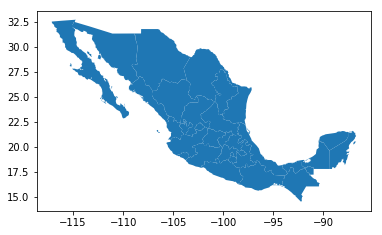

In [6]:
estados.plot()

### b. Carga de archivo para explorar

In [7]:
#Crea el archivo. Vamos a cargar uno que incluya sectores creativos
zf = zipfile.ZipFile(os.path.join(denue_dir, 'denue_00_51_csv.zip'))

#Extrae los nombres
zf_names = zf.infolist()
for f in zf_names:
    print(f.filename)

diccionario_de_datos/denue_diccionario_de_datos.csv
conjunto_de_datos/denue_inegi_51_.csv
metadatos/metadatos_denue.txt


#### Carga el diccionario de datos

In [8]:
#Diccionario de datos del DENUE

#Nombre del diccionario de datos
data_dict_filename = zf_names[0].filename

#Lectura
denue_dictionary = pd.read_csv(zf.open(data_dict_filename), encoding='latin-1')

#Guardamos el diccionario
denue_dictionary.to_csv(os.path.join(processed_dir, '{date}_denue_data_dictionary.csv'.format(date=today_str)))

#### Carga los datos

In [9]:
#Nos interesa el archivo 'denue_inegi_51_.csv', index=1
denue_data = zf_names[1]

#Obtenemos el nombre (que usaremos para abrir los datos)
denue_file_name = denue_data.filename

In [10]:
#Se puede leer con pandas fácilmente
denue_51 = pd.read_csv(zf.open(denue_file_name), encoding='latin-1', dtype={"numero_ext": str, "numero_int": str})

In [11]:
#Aquí está
denue_51.head()

,id,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,nom_v_e_1,...,localidad,ageb,manzana,telefono,correoelec,www,tipoUniEco,latitud,longitud,fecha_alta
0,7621927,AGENCIA DE MARKETIN 33.1,NaN,518210,"Procesamiento electrónico de información, hosp...",6 a 10 personas,AVENIDA,LICENCIADO ADOLFO LOPEZ MATEOS ORIENTE,CALLE,NINGUNO,...,Aguascalientes,0816,42.0,NaN,GABRIEL@RODRIGUEZ.MX,WWW.TREINTAYTRES.UNO,Fijo,21.878487,-102.280774,2019-11
1,8500411,AGENCIA NOTICIOSA TURBINA INFORMATIVA,TURBINA INFORMATIVA SA DE CV,519110,Agencias noticiosas,0 a 5 personas,BOULEVARD,LICENCIADO ADOLFO RUIZ CORTINES,CALLE,VERGELITOS,...,Aguascalientes,1674,4.0,NaN,NaN,NaN,Fijo,21.873049,-102.331844,2019-11
2,17294,ALESTRA,ALESTRA S DE RL DE CV,517311,Operadores de servicios de telecomunicaciones ...,0 a 5 personas,AVENIDA,UNIVERSIDAD,CALLE,SIERRA DE LA CANELA,...,Aguascalientes,2259,19.0,NaN,INFO@ALESTRA.MX,WWW.ALESTRA.MX,Fijo,21.917209,-102.313807,2011-03
3,15779,ANIMACTIVA,ANIMACTIVA SA DE CV,511210,Edición de software y edición de software inte...,0 a 5 personas,CALLE,FELIPE SERRANO,CALLE,FELIPE SERRANO,...,Aguascalientes,3098,7.0,NaN,MANAGEMENT@ANIMACTIVA.MX,WWW.ANIMACTIVA.MX,Fijo,21.923799,-102.268272,2010-07
4,7702887,ARCHIVO DE CONCENTRACIÓN MUNICIPAL,MUNICIPIO DEL ESTADO DE AGUASCALIENTES,519122,Bibliotecas y archivos del sector público,6 a 10 personas,CALLE,NINGUNO,AVENIDA,LICENCIADO ADOLFO LOPEZ MATEOS ORIENTE,...,Aguascalientes,0816,13.0,NaN,NaN,WWW.AGS.GOB.MX,Fijo,21.878240,-102.280318,2019-11


In [12]:
#Contiene 19K observaciones y 41 variables
denue_51.shape

(15578, 41)

In [13]:
#10 sectores principales
denue_51.nombre_act.value_counts()[:10]

Bibliotecas y archivos del sector público                     4475
Operadores de servicios de telecomunicaciones alámbricas      2365
Otros servicios de telecomunicaciones                         2234
Transmisión de programas de radio                             1313
Exhibición de películas y otros materiales audiovisuales       885
Operadores de servicios de telecomunicaciones inalámbricas     579
Edición de periódicos integrada con la impresión               516
Transmisión de programas de televisión                         364
Edición de otros materiales integrada con la impresión         275
Bibliotecas y archivos del sector privado                      250
Name: nombre_act, dtype: int64

In [14]:
#¿Cómo se ven los códigos de sector? Podemos encontrarlos en el lookup del NAICS

list(set(denue_51.codigo_act))[:5]

[512130, 511111, 511112, 515210, 511121]

Tienen 7 dígitos

In [15]:
#Revisar lookup. Hacemos esto eliminando códigos duplicados en los datos. 
code_name_lu = denue_51[['codigo_act','nombre_act']].drop_duplicates('codigo_act').reset_index(drop=True)

 
#Hemos comparado los códigos en los datos con los códigos en el archivo NAICS y coinciden. 
#Vamos a trabjar con el archivo NAICS, complementado con los códigos del reporte de Nesta 2016.

In [16]:
denue_51.telefono

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
5               NaN
6               NaN
7        4499501717
8               NaN
9               NaN
10              NaN
11       4499158257
12              NaN
13       4499783228
14              NaN
15              NaN
16              NaN
17       4499948325
18              NaN
19              NaN
20       4492658315
21              NaN
22              NaN
23       4499181412
24              NaN
25              NaN
26              NaN
27              NaN
28       4492513382
29              NaN
            ...    
15548           NaN
15549           NaN
15550           NaN
15551           NaN
15552    4639525347
15553           NaN
15554           NaN
15555           NaN
15556           NaN
15557           NaN
15558           NaN
15559           NaN
15560    4968645079
15561           NaN
15562           NaN
15563           NaN
15564           NaN
15565           NaN
15566           NaN


### Combinar DENUE y lookup

In [17]:
#Hay que comparar esto con los metadatos y ver que obtenemos
denue_51_creative = pd.merge(denue_51,naics_creative_lookup,left_on='codigo_act',
                            right_on='code_int',how='left')

#Compañías de software
denue_51_creative.loc[denue_51_creative.creative_sector=='software',:].head()

,id,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,nom_v_e_1,...,fecha_alta,code_en,sector_spanish,code_es,sector_english,creative_nesta_2016,creative_refined,creative_sector,has_creative,code_int
0,7621927,AGENCIA DE MARKETIN 33.1,NaN,518210,"Procesamiento electrónico de información, hosp...",6 a 10 personas,AVENIDA,LICENCIADO ADOLFO LOPEZ MATEOS ORIENTE,CALLE,NINGUNO,...,2019-11,518210.0,"Procesamiento electrónico de información, hosp...",518210.0,"Electronic data processing, hosting, and other...",1.0,1.0,software,1.0,518210.0
3,15779,ANIMACTIVA,ANIMACTIVA SA DE CV,511210,Edición de software y edición de software inte...,0 a 5 personas,CALLE,FELIPE SERRANO,CALLE,FELIPE SERRANO,...,2010-07,511210.0,Edición de software y edición de software inte...,511210.0,"Software publishing, and integrated software p...",1.0,1.0,software,1.0,511210.0
65,6765767,FACTURANET,FACTURANET SA DE CV,518210,"Procesamiento electrónico de información, hosp...",0 a 5 personas,CALLE,SAN JULIÁN,CALLE,SIERRA DE LAS PALOMAS,...,2016-10,518210.0,"Procesamiento electrónico de información, hosp...",518210.0,"Electronic data processing, hosting, and other...",1.0,1.0,software,1.0,518210.0
76,23496,IMPREEXPRES,NaN,518210,"Procesamiento electrónico de información, hosp...",0 a 5 personas,CALLE,FRANCISCO G. HORNEDO,CALLE,16 DE SEPTIEMBRE,...,2010-07,518210.0,"Procesamiento electrónico de información, hosp...",518210.0,"Electronic data processing, hosting, and other...",1.0,1.0,software,1.0,518210.0
78,39350,INNOVACIÓN Y VANGUARDIA DIGITAL,INNOVACIÓN Y VANGUARDIA DIGITAL SA DE CV,518210,"Procesamiento electrónico de información, hosp...",0 a 5 personas,AVENIDA,UNIVERSIDAD,CALLE,SIERRA DE LA CANELA,...,2014-12,518210.0,"Procesamiento electrónico de información, hosp...",518210.0,"Electronic data processing, hosting, and other...",1.0,1.0,software,1.0,518210.0


In [18]:
#Sectores creativos en los datos
denue_51_creative.creative_sector.value_counts()

libraries_museums        4725
film_radio_tv            3183
publishing               1626
software                  324
music_performing_arts     213
Name: creative_sector, dtype: int64

In [19]:
#Tamaño
pd.crosstab(denue_51_creative.per_ocu,denue_51_creative.creative_sector)

creative_sector,film_radio_tv,libraries_museums,music_performing_arts,publishing,software
per_ocu,,,,,
0 a 5 personas,1271,3938,175,904,114
101 a 250 personas,46,7,0,65,11
11 a 30 personas,754,271,15,230,79
251 y más personas,19,2,1,26,19
31 a 50 personas,315,45,3,73,16
51 a 100 personas,215,18,1,81,16
6 a 10 personas,563,444,18,247,69


In [20]:
#States
pd.crosstab(denue_51_creative.entidad,denue_51_creative.creative_sector)

creative_sector,film_radio_tv,libraries_museums,music_performing_arts,publishing,software
entidad,,,,,
AGUASCALIENTES,24,36,2,23,8
BAJA CALIFORNIA,118,79,3,37,11
BAJA CALIFORNIA SUR,35,47,2,19,6
CAMPECHE,37,41,1,19,1
CHIAPAS,155,173,8,37,3
CHIHUAHUA,122,138,6,41,19
CIUDAD DE MÉXICO,383,312,39,306,97
COAHUILA DE ZARAGOZA,116,132,3,42,2
COLIMA,33,49,2,20,1


In [21]:
#Municipios
pd.crosstab(denue_51_creative.municipio,denue_51_creative.creative_sector)[:20]

creative_sector,film_radio_tv,libraries_museums,music_performing_arts,publishing,software
municipio,,,,,
Abalá,0,1,0,0,0
Abasolo,0,6,0,0,0
Abejones,0,1,0,0,0
Acacoyagua,1,1,0,0,0
Acajete,0,7,0,0,0
Acala,0,0,0,1,0
Acambay de Ruíz Castañeda,0,2,0,0,0
Acanceh,0,1,0,0,0
Acapetahua,0,2,0,0,0


## c. Cargar todos los datos

**Plan**


Voy a crear una clase que tome un nombre de archivo, lo lea y extraiga todas las industrias creativas y así mismo obtenga la distribución de industrias en todas las otras áreas, así como la distribución de su tamaño (la cual podemos utilizar para normalizar los datos). 

Incluye:

1. Crear una lista de todos los archivos que quiero cargar
2. Escribir una clase con: 
 * Un método de lectura para el archivo csv y asignar nombres limpios a las variables 
 * Un método get_creative que combine el archivo con el lookup naics_creative y arroje todas las coincidencias
 * Un método area_stats que genere cuentas de compañías por estado y municipio
3. Implementar la clase mientras me voy a correr :-)


In [22]:
class ReadProcessDenue():
    
    '''
    DenueProcess is a class that takes a filename for a zip file and:
   
    -Extracts the csv content (read method)
    -Cleans variable names (process method)
    -Merges with the NAICS Lookup (get_creative method)
    -Generates area counts for all sectors (area_counts method).
    
    It stores the outputs in a creative_businesses attribute, a state_counts attribute and a local_counts 
    attribute. 

    '''
    
    def __init__(self,filepath):
        '''
        Initialise the class with a filepath
        
        '''
        
        self.filepath = filepath
        
    def read_file(self):
        '''
        Read the csv
        
        '''
        #Get the filepath
        filepath = self.filepath
        
        #Read the zipfile
        zf = zipfile.ZipFile(filepath)
        
        #Get the name of the datafile
        zipfilenames = [f.filename for f in zf.infolist()]
        data_file_name = [f for f in zipfilenames if re.search("denue_inegi", f, re.IGNORECASE)][0]
        
        #Read the file
        #denue_data = pd.read_csv(filepath)
        denue_data = pd.read_csv(zf.open(data_file_name), encoding='utf-8',
                                 dtype={"numero_ext": str, "numero_int": str,
                                       "www": str, "telefono": str, "manzana":str})
        
        
        #Change column names (the 2015 figures came with uppercase)
        denue_data.columns = ['id', 'nom_estab', 'raz_social', 'codigo_act',
                              'nombre_act', 'per_ocu', 'tipo_vial', 'nom_vial',
                              'tipo_v_e_1', 'nom_v_e_1', 'tipo_v_e_2', 'nom_v_e_2',
                              'tipo_v_e_3', 'nom_v_e_3', 'numero_ext', 'letra_ext',
                              'edificio', 'edificio_e', 'numero_int', 'letra_int',
                              'tipo_asent', 'nomb_asent', 'tipoCenCom', 'nom_CenCom',
                              'num_local', 'cod_postal', 'cve_ent', 'entidad',
                              'cve_mun', 'municipio', 'cve_loc', 'localidad', 'ageb',
                              'manzana', 'telefono', 'correoelec', 'www', 'tipoUniEco',
                              'latitud', 'longitud', 'fecha_alta']

            #Assign the denue data to the denue_data attribute
        self.denue_data = denue_data

    
    def get_creative(self,extract_all=False):
        '''
        Extracts creative companies
        
        '''
        #Read all denue data
        all_denue = self.denue_data
        
        #Merge with the creative lookup
        
        
        if extract_all == False:
            creative_denue = pd.merge(all_denue,naics_creative_lookup,
                                      left_on='codigo_act',right_on='code_int',how='inner').reset_index(drop=True)
            
        else:
            creative_denue = pd.merge(all_denue,naics_creative_lookup,
                                      left_on='codigo_act',right_on='code_int',how='left').reset_index(drop=True)
            
        
        
        #Convert the telephone number to a string
        #NB the if else is to deal with missing values in the telefone field
        #creative_denue['telefono'] = [str(int(x)) if type(x)!=float else np.nan for x in creative_denue['telefono']]
        
        
        #We will store two versions: a complete file and a short file with less variables of interest
        
        #Complete version with somewhat messy variable names
        self.denue_creative_long = creative_denue
        
        #Also store the tidy version
        #NB we need to re-concatenate it with the sector info we merged above
        self.denue_creative_short = pd.concat([tidy_denue_data(creative_denue),
                                               creative_denue[['creative_nesta_2016','creative_refined',
                                                               'creative_sector','has_creative']]],axis=1)
        #self.denue_all = pd.concat(tidy_denue_data())
        
        
                                               
    def get_context_stats(self):
        '''
        This extracts contextual information that we will use to compare and normalise the creative data.
        
        NB this is only preliminary. I assume we will want to do more finely grained comparisons. We
        can modify this method to extract what we need to do that.
        
        For now we will get:
        -State counts
        -Municipio counts
        -Sizeband counts
        -Sizeband by state and municipality counts
        -Incorporation date counts
        
        '''
        
        #Load all denue data
        all_denue = self.denue_data
        
        #Extract contextual reports with a function
        self.context_stats = get_context(all_denue)

In [23]:
def tidy_denue_data(denue_data):
    '''
    This function returns a clean denue file with a few relevant variables
    We will use this for economic analysis
    NB the variables we are removing will nevertheless be important for marketing
    
    '''
    

    
    interesting_vars = ['id','nom_estab','raz_social','codigo_act','nombre_act','per_ocu',
                       'cod_postal','entidad','municipio','localidad','telefono','correoelec','www',
                       'tipoUniEco','latitud','longitud','fecha_alta']
    
    tidy_name_vars = ['id','name','legal_name','sector','sector_description','employee_sizeband',
                      'postcode','state','municipality','location','telephone','email','website','type_organisation',
                      'lat','lon','incorp_date']
    
    denue_selected = denue_data[interesting_vars]
    
    denue_selected.columns = tidy_name_vars
    
    return(denue_selected)

def get_context(denue_data):
    '''
    This function extracts some contextual data as part of the get_context_stats method in the ReadProcessDenue
    class.
    
    '''
    
    #Tidy data (having standard names will help processing later)
    tidy_denue = tidy_denue_data(denue_data)
    
    #Generate a bunch of counts
    state_counts, municipality_counts,sizeband_counts,incorp_date_counts = [tidy_denue[x].value_counts() for x in 
                                                         ['state','municipality',
                                                          'employee_sizeband','incorp_date']]
    
    #And a couple of crosstabs
    state_sizeb_crosstabs,municipality_sizeb_crosstabs = [pd.crosstab(tidy_denue[x],
                                                                      tidy_denue['employee_sizeband']) for x in
                                                         ['state','municipality']]
    
    #Put everything in a list
    out_list = [state_counts,municipality_counts,sizeband_counts,incorp_date_counts,
               state_sizeb_crosstabs,municipality_sizeb_crosstabs]
    
    return(out_list)

In [24]:
def crear_dataframe(files):
    denue_eda_outputs = []
    
    #We'll run it as an old school loop
    for dataset in files:
        
        #For each dataset...
        #We print it to keep track of things
        
        print(dataset)
        
        #Create the path
        input_file_path = os.path.join(denue_dir, dataset)
        
        #Initialise the class
        denue_object = ReadProcessDenue(input_file_path)
        
        #Read the data
        denue_object.read_file()
        
        #Get the creative data
        denue_object.get_creative(extract_all=True)
        
        #Get the contextual data
        denue_object.get_context_stats()
        
        #Put everything in a list
        outputs_of_interest = [denue_object.denue_creative_short,denue_object.denue_creative_long,
                              denue_object.context_stats]
        
        #Append to DENUE
        denue_eda_outputs.append(outputs_of_interest) 
    
    #This concatenates all the creative companies into a single dataframe
    return denue_eda_outputs

In [25]:
#Let's run this

#Extract a list of files in the 'sector data' directory
all_sector_files = os.listdir(denue_dir)
sector_files_csv = [x for x in all_sector_files if re.search('denue_00_[0-9\-]+_1118_csv',x)]

#This concatenates all the creative companies into a single dataframe
denue_eda_outputs = crear_dataframe(sector_files_csv)
creative_tidy = pd.concat([x[0] for x in denue_eda_outputs]).reset_index(drop=True)
creative_tidy.to_csv(os.path.join(processed_dir, '{today}_denue_creative.csv'.format(today=today_str)))

denue_00_21_1118_csv.zip
denue_00_61_1118_csv.zip
denue_00_11_1118_csv.zip
denue_00_43_1118_csv.zip
denue_00_56_1118_csv.zip
denue_00_51_1118_csv.zip
denue_00_72_1118_csv.zip
denue_00_93_1118_csv.zip
denue_00_81_1118_csv.zip
denue_00_48-49_1118_csv.zip
denue_00_31-33_1118_csv.zip
denue_00_46591-46911_1118_csv.zip
denue_00_46111_1118_csv.zip
denue_00_46321-46531_1118_csv.zip
denue_00_53_1118_csv.zip
denue_00_54_1118_csv.zip
denue_00_46112-46311_1118_csv.zip
denue_00_62_1118_csv.zip
denue_00_22_1118_csv.zip
denue_00_55_1118_csv.zip
denue_00_52_1118_csv.zip
denue_00_23_1118_csv.zip
denue_00_71_1118_csv.zip


## 2. Explorar los datos

Aquí exploramos los datos del DENUE que hemos cargado. 

La exploración tiene dos ejes:

* Descriptivos
  * Distribución por sector
  * Geografía del sector (incluye mapas y especialización)
  * Incorpora fechas ('age'?)
* Análisis comparativo
  * Compara sizebands de industrias creativas con el resto de la economía u otros sectores
  * Compare fechas de incorporación de las industrias creativas con el resto de la economía u otros sectores
* Disponibilidad de detalles de contacto
  * Información para el diseño e implementación de la encuesta 


### Distribución sectorial

#### ¿Cuántas industrias creativas hay en México, y en qué sectores?

In [26]:
#De acuerdo a la definición NAICS de Nesta
nesta_2016_def = creative_tidy.loc[creative_tidy.creative_nesta_2016==1,:]

nesta_ref = creative_tidy.loc[creative_tidy.creative_refined==1,:]

print("According to the Nesta 2016 NAICs definition there are {num} creative business in Mexico".
      format(num=len(nesta_2016_def)))

print('\n')

print("According to the refined definition there are {num} creative business in Mexico".
      format(num=len(nesta_ref)))

According to the Nesta 2016 NAICs definition there are 91368 creative business in Mexico


According to the refined definition there are 70005 creative business in Mexico


In [27]:
#¿Tienen IDs únicas? 

#Sí. En todo caso deberíamos revisar su status legal
len(set(nesta_2016_def.id))

91368

In [28]:
#¿qué porcentaje del total representan?

In [29]:
nesta_2016_def.loc[nesta_2016_def.website.isna()==False,:][
    ['id','name','creative_sector','employee_sizeband','website']].to_csv(
    os.path.join(processed_dir,'denue_website_data.csv'))

In [30]:
total_businesses_denue = np.sum([x[2][0].sum() for x in denue_eda_outputs])

#Percentage of creative businesses in DENUE
100*90004/total_businesses_denue

1.7713166516833059

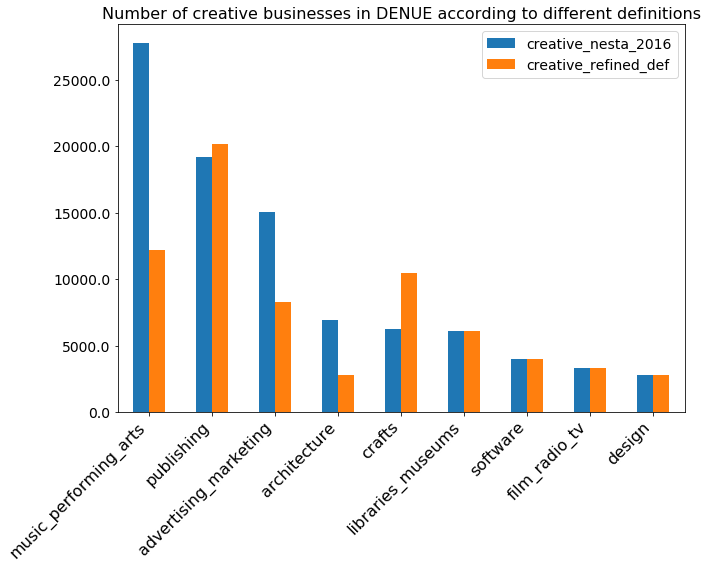

In [31]:
#Comparar ambas:

#Creamos una tabla que concatena ambos sectores
creative_comp_table = pd.concat([nesta_2016_def['creative_sector'].value_counts(),
                                nesta_ref['creative_sector'].value_counts()],axis=1,sort=True)

#Renombramos las columnas
creative_comp_table.columns=['creative_nesta_2016','creative_refined_def']

#Ordenamos los valores
creative_comp_table.sort_values('creative_nesta_2016',ascending=False,inplace=True)

#Extraemos el índice de la tabla para ordenar gráficas después
sectors_sorted = creative_comp_table.index


fig,ax = plt.subplots(figsize=(10,8))

creative_comp_table.plot.bar(ax=ax)


ax.set_yticklabels(ax.get_yticks(),size=14)
ax.set_xticklabels(labels=creative_comp_table.index,size=16,rotation=45,ha='right')
ax.legend(fontsize=14)
ax.set_title('Number of creative businesses in DENUE according to different definitions',fontsize=16)

plt.tight_layout()

plt.savefig(os.path.join(fig_dir,'{date}_sector_bar_chart.pdf'.format(date=today_str)))

Si revisamos el archivo `naics_creative_lookup_short` podemos ver que explica las difereencias:


* Música y artes escénicas en Nesta 2016 incluye muchas actividades genéricas y educacionales relacionadas al deporte
* Publicidad y mercadotecnia en Nesta 2016 incluye actividades de consultoría administrativa
* Architecture in Nesta 2016 includes engineering and drafting services, building inspection and other things unrelated to architectural design
* Arquitectura en Nesta 2016 incluye servicios de ingeniería y planos, inspección de edificios y otros elementos no relacionados al diseño arquitectónico. 
* Artesanías en Nesta 2016 no incluye algunas actividades relacionadas a la joyería y el repujado

Como se mencionó anteriormente, nos enfocaremos en la definición de Nesta por ahora. Podemos cambiar la definición depués. 

#### ¿Cuánta gente trabaja en el sector?

In [32]:
#Nombramos las variables cis por industrias creativas  
cis = nesta_2016_def.copy()

#Poner estados en minúscula para que coincidan con los datos de mapas
cis['state'] = [x.lower().strip() for x in cis['state']]


In [33]:
#Esta es la distribución de tamaño

size_distribution = pd.DataFrame(cis['employee_sizeband'].value_counts())
size_distribution['share_pc'] = size_distribution/size_distribution.sum()

sizeb_sorted = size_distribution.index

size_distribution

,employee_sizeband,share_pc
0 a 5 personas,68942,0.754553
6 a 10 personas,10625,0.116288
11 a 30 personas,8208,0.089835
31 a 50 personas,1960,0.021452
51 a 100 personas,915,0.010014
101 a 250 personas,442,0.004838
251 y más personas,276,0.003021


In [34]:
#Banda de tamaño por subsector creativo comparado con industrias creativas en otros y todos los sectores

sector_size = pd.crosstab(cis['creative_sector'],cis['employee_sizeband'],normalize=0)

#Combinamos con la distribución por tamaño de arriba y con una tabla de distribución de tamaño para todas las compañías

#Crea una distribución de bandas de tamaño para todos los negocios en el DENUE
sizeband_distr_all= pd.concat([x[2][2] for x in denue_eda_outputs],axis=1,sort=True).sum(axis=1)

#Calculamos porcentajes
sizeband_distr_shares = sizeband_distr_all/sizeband_distr_all.sum()

#Concatenamos todo
sector_size_all = pd.concat([sector_size.T,size_distribution['share_pc'],sizeband_distr_shares],axis=1,sort=True)

#Renombramos todas las columnas de sectores creativos y otros sectores
sector_size_all.rename(columns={'share_pc':'creative_industries',0:'all_sectors'},inplace=True)

#Queremos mostrar todos los subsectores creativos primero, ordenados por tamaño.


sectors_sorted = sector_size_all.T.sort_values(['0 a 5 personas'],ascending=True).index

#Colocamos las industrias creativas y todos los sectores al final. 
sectors_sorted = [x for x in sectors_sorted if x not in ['all_sectors','creative_industries']]+[
    'creative_industries','all_sectors']

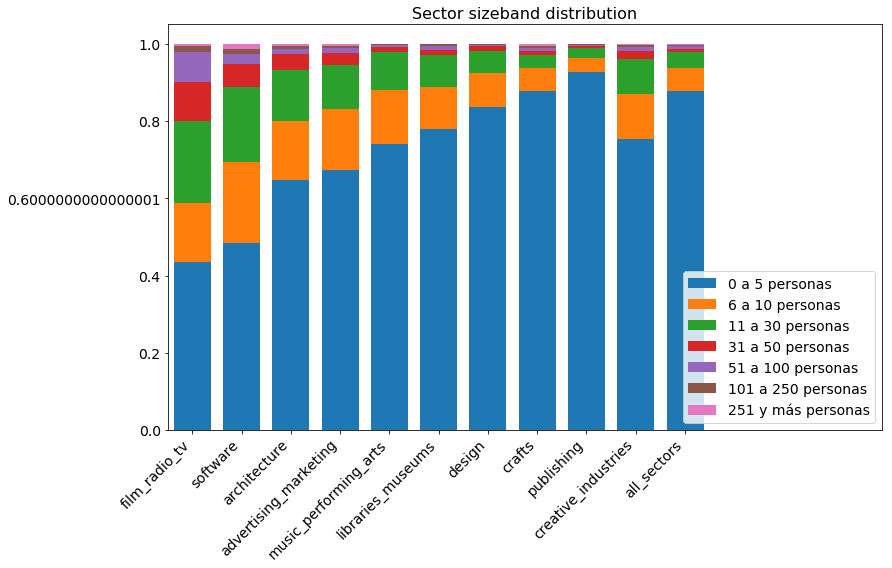

In [35]:
fig,ax = plt.subplots(figsize=(12.5,8))

sector_size_all.T.loc[sectors_sorted,sizeb_sorted].plot.bar(stacked=True,ax=ax,width=0.75,
                                                      title='Size distribution by sector')

#Ajustamos límites para acomodar la leyenda en la derecha
ax.set_xlim((-0.5,14))

ax.set_yticklabels(ax.get_yticks(),size=14)
ax.set_xticklabels(labels=sectors_sorted,size=14,rotation=45,ha='right')
ax.legend(fontsize=14)
ax.set_title('Sector sizeband distribution',fontsize=16)

plt.tight_layout()

plt.savefig(os.path.join(fig_dir,'{date}_size_distribution.pdf'.format(date=today_str)))



In [36]:
#Creamos un estimado de punto medio

In [37]:
def get_midpoint(sizeband_value):
    '''
    This function extracts a midpoint estimate from the sizeand variable in the DENUE data
    
    '''
    
    #Con la excepción de '251 y mas...' las categorías están nombradas como 'x a y' personas. 
    #Vamos a separar en whitespace y extraer los valores, para convertirnos en enteros y sacar su promedio
    
    #Asumimos que el valor máximo es 251. Quizá podríamos encuestar estas empresas para preguntar su número de empleados. 
    #¿Quiénes son?
    
    if '251' in sizeband_value:
        estimate = 251
        
    else:
        #Split
        split = sizeband_value.split(" ")

        #Obtener la media
        estimate = np.mean([int(split[0]),int(split[2])])
        
    return(estimate)
        
    

In [38]:
#Aquí está
cis['employment_estimate'] = [get_midpoint(x) for x in cis.employee_sizeband]

In [39]:
cis.employment_estimate.sum()

720928.5

Este número es significativamente más bajo que lo que dicen otras fuentes, ej. '2m de trabajos incluyendo directos e indirectos' según [este blog](https://www.forbes.com.mx/la-cultura-riqueza-mal-vista/) (Resalta que no se incluye la definición). Resalta también que los datos truncos a la derecha implica que probablemente estamos subestimando el tamaño de las compañías del DENUE (por ejemplo, de acuerdo con [Wikipedia](https://es.wikipedia.org/wiki/Televisa), Televisa emplea 15,000 personas pero estos datos estimarían su número de empleados en 11.

¿Quizá podríamos comparar compañías más grandes con Wikipedia para extraer su número de empleados? ¿Pero quiénes son?

In [40]:
large_company_list = list(cis.loc[cis.employment_estimate>250,'name'])

In [41]:
large_company_list[:10]

#Hay algo de repetición en los nombres. ¿Son diferentes organizaciones o duplicados?

['AEZ A C',
 'ESCUELA NACIONAL DE ARTES PLASTICAS',
 'IDEA',
 'THE ANGLO MEXICAN FOUNDATION AC',
 'IMAC',
 'INSTITUTO PARA FORMACIÓN Y DESARROLLO VOLKSWAGEN SC',
 'CENTRO EDUCATIVO Y PRODUCTIVO BANCOMER-TECNOLÓGICO DE MONTERREY INCUBADORA SOCIAL',
 'ESTACION DE RADIO GRUPO ACIR',
 'SISTEMA CHIAPANECO DE RADIO TELEVISION Y CINEMATOGRAFIA',
 'DATAMARK DE MEXICO, S.A.DE C.V.']

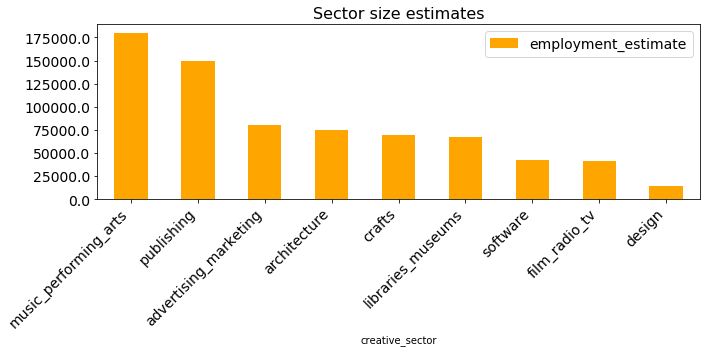

In [42]:
#Crear estimados de tamaño de sector
sector_size_estimates = cis.groupby('creative_sector')['employment_estimate'].sum().sort_values(ascending=False)

fig,ax = plt.subplots(figsize=(10,5))

sector_size_estimates.plot.bar(ax=ax,color='orange',title='Sector size estimates')


ax.set_yticklabels(ax.get_yticks(),size=14)
ax.set_xticklabels(labels=creative_comp_table.index,size=14,rotation=45,ha='right')
ax.legend(fontsize=14)
ax.set_title('Sector size estimates',fontsize=16)

plt.tight_layout()

plt.savefig(os.path.join(fig_dir,'{date}_size_estimates.pdf'.format(date=today_str)))

#### Comparing employment in CIs with other industries

In [43]:
#Esto va a concatenar cuentas de negocios en distintas bandas de tamaño para cada sector fuera de las industrias creativas

all_sizebands = pd.concat([x[2][2] for x in denue_eda_outputs],axis=1,sort=True).sum(axis=1).reset_index(drop=False)

#Producimos el estimado medio de los datos
all_sizebands['midpoint'] = [get_midpoint(x) for x in all_sizebands['index']]

#Multiplica el estimado medio por el número de compañías en cada banda de tamaño
all_employment = np.sum(all_sizebands['midpoint']*all_sizebands[0])

#Divide el número de empleados creativos sobre el número total de empleados para obtener un estimado

np.round(100*699838.0/all_employment,3)

2.404

2.5% de todo el empleo se da en industrias creativas

### Otras comparaciones inter-sectoriales







#### Fechas de incorporación

Fecha de cuándo distintas organizaciones se unieron al registro. Esto no es lo mismo que la edad de la empresa. 

Vamos a revisar los datos por subsector y en comparación con las industrias creativas. 



In [44]:
#¿Cuántos valores de incorporación hay?

cis_join_date = cis.incorp_date.value_counts()

cis_join_date.name='creative_industries'

cis_subsector_join_date = pd.crosstab(cis.incorp_date,cis.creative_sector)

#¿Cómo se comparan con datos de otros sectores?
#Como se hizo previamente, extraemos información de los resultados del DENUE y sumamos para
 #obtener el número total de compañías por fecha de incorporación al registro. 

all_join_date = pd.concat([x[2][3] for x in denue_eda_outputs],axis=1,sort=True).sum(axis=1)
all_join_date.name='all_sectors'

#Hay que juntar todo

#Queremos ordenar las fechas de la más vieja a la más reciente
merged_join_date =pd.concat([cis_subsector_join_date,cis_join_date,all_join_date],axis=1,sort=True).reset_index(drop=False)

#Combinamos fechas de inclusión por año
merged_join_date['year'] = [int(x.split("-")[1]) for x in merged_join_date['index']]

#Sumar por año y reindex
merged_join_date = merged_join_date.drop('index',axis=1).groupby('year').sum().apply(lambda x: x/x.sum(),axis=0)

#Ordenar sectores por 'novedad' (importancia de incoporaciones entre 2014 y 2016) con all_sectors y creative_industries al final
sectors_sorted_date = merged_join_date.T.iloc[:,-2:].sum(axis=1).sort_values(ascending=False).index

sectors_sorted_date = [x for x in sectors_sorted_date if x not in [
    'creative_industries','all_sectors']] + ['creative_industries','all_sectors']

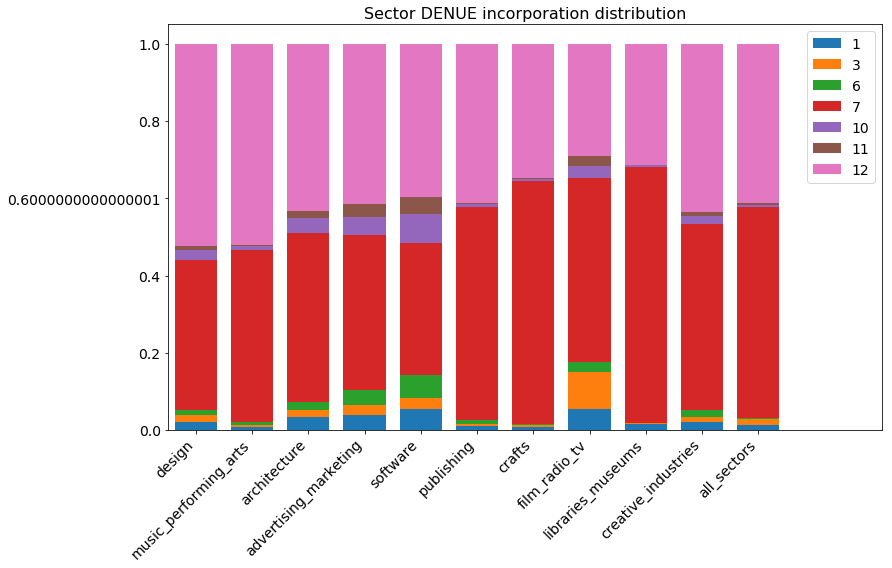

In [45]:
fig,ax = plt.subplots(figsize=(12.5,8))

merged_join_date.T.loc[sectors_sorted_date,:].plot.bar(stacked=True,ax=ax,width=0.75,
                                                      title='DENUE registering date by sector')

#Ajustamos los límites para la leyenda en la derecha
ax.set_xlim((-0.5,12.2))


ax.set_yticklabels(ax.get_yticks(),size=14)
ax.set_xticklabels(labels=sectors_sorted_date,size=14,rotation=45,ha='right')
ax.legend(fontsize=14)
ax.set_title('Sector DENUE incorporation distribution',fontsize=16)

plt.tight_layout()

plt.savefig(os.path.join(fig_dir,'{date}_incorp_distribution.pdf'.format(date=today_str)))

plt.tight_layout()

(-0.5, 7.5)

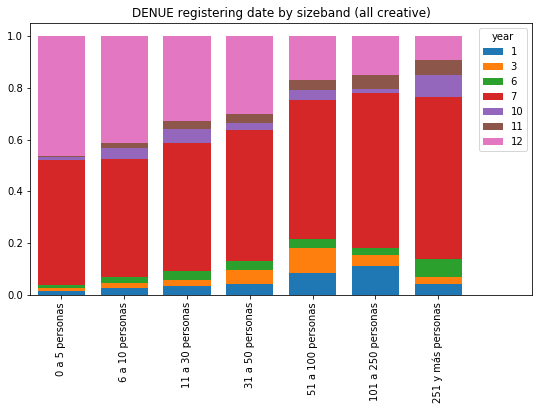

In [46]:
#Finalmente, revisamos las fechas de incorporación por tamaño

#Crosstab
inc_dates_size = pd.crosstab(cis.incorp_date,cis.employee_sizeband,normalize=1).loc[:,sizeb_sorted]

#Como se hizo previamente, extraemos el año de la variable de la incorporación para poder manipular más fácilmente
inc_dates_size['year'] = [int(x.split("-")[1]) for x in inc_dates_size.index]


fig,ax = plt.subplots(figsize=(9,5))

inc_dates_size.groupby('year').sum().T.plot.bar(stacked=True,ax=ax,width=0.75,
                                                      title='DENUE registering date by sizeband (all creative)')

#Ajustamos los límites para acomodar la leyenda en la derecha
ax.set_xlim((-0.5,7.5))

Los resultados sorprenden - muchas compañías grandes han sido agregadas a los datos en años recientes. Hay que revisar algunas.

In [47]:
cis.loc[(['2016' in x for x in cis['incorp_date']]) & (cis.employment_estimate>250),:].head()

,id,name,legal_name,sector,sector_description,employee_sizeband,postcode,state,municipality,location,...,website,type_organisation,lat,lon,incorp_date,creative_nesta_2016,creative_refined,creative_sector,has_creative,employment_estimate
425627,6770519,ESTACION DE RADIO GRUPO ACIR,RADIO XHCOC S DE RL DE CV,515110,Transmisión de programas de radio,251 y más personas,28017.0,colima,Colima,Colima ...,...,NaN,Fijo,19.249498,-103.707877,2016-10,1.0,1.0,film_radio_tv,1.0,251.0
427818,6503428,DISH,MVS NET SA DE CV,515120,Transmisión de programas de televisión,251 y más personas,15530.0,ciudad de méxico,Venustiano Carranza,Venustiano Carranza ...,...,NaN,Fijo,19.433883,-99.088800,2016-01,1.0,1.0,film_radio_tv,1.0,251.0
428288,6486192,"LA TIENDA DE LA IMAGEN, S.A. DE C.V.","LA TIENDA DE LA IMAGEN, S.A. DE C.V.",512112,Producción de programas para la televisión,251 y más personas,11550.0,ciudad de méxico,Miguel Hidalgo,Miguel Hidalgo ...,...,WWW.LATIENDADELAIMAGEN.COM.MX,Fijo,19.431804,-99.195697,2016-01,1.0,1.0,film_radio_tv,1.0,251.0
428388,6774890,MICROSOFT MEXICO,MICROSOFT MEXICO S DE RL DE CV,511210,Edición de software y edición de software inte...,251 y más personas,1376.0,ciudad de méxico,Álvaro Obregón,Álvaro Obregón ...,...,WWW.MICROSOFT.COM,Fijo,19.366606,-99.264499,2016-10,1.0,1.0,software,1.0,251.0
428955,6516106,TELEVISA SA DE CV,TELEVISA SA DE CV,515120,Transmisión de programas de televisión,251 y más personas,1210.0,ciudad de méxico,Álvaro Obregón,Álvaro Obregón ...,...,NaN,Fijo,19.377347,-99.252084,2016-01,1.0,1.0,film_radio_tv,1.0,251.0


En general los números son pequeños (36)

#### ¿Dónde está el sector?

Vamos a examinar su geografía según los siguientes términos:
* Número total de niveles de actividad por estado y municipio, y totales por subsector
* Valores normalizados por actividad en otras industrias

In [48]:
cis.groupby('state')['employment_estimate'].sum()

state
aguascalientes                       9019.0
baja california                     19976.5
baja california sur                  4604.0
campeche                             6388.5
chiapas                             15080.5
chihuahua                           17651.5
ciudad de méxico                   195929.5
coahuila de zaragoza                17389.0
colima                               4399.5
durango                              7758.5
guanajuato                          24679.5
guerrero                            11295.0
hidalgo                             10200.0
jalisco                             52549.5
michoacán de ocampo                 16741.5
morelos                              8203.5
méxico                              53885.5
nayarit                              4730.5
nuevo león                          45598.5
oaxaca                              14408.5
puebla                              30176.5
querétaro                           17517.0
quintana roo              

In [49]:
#Terminemos con nun mapa

#Distribución de empresas por estado
state_creative_counts = cis['state'].value_counts()

#Estimados de empleo
state_employment_estimates = cis.groupby('state')['employment_estimate'].sum()

#Combinar estimados de negocios y empleados
state_all_creative = pd.concat([state_creative_counts,state_employment_estimates],axis=1,sort=True)

#Recuerda que ya cargamos el shapefile. Convertimos los nombres de los estados en minúsculas para combinar los datos
estados['ESTADO'] = [x.lower().strip() for x in estados['ESTADO']]

#Usan distintos nombres para la Ciudad de México (DENUE lo nombra Distrito Federal y 
#el shapefile Ciudad de Mexico. 
#Se tiene que arreglar

# Shapefile state names need to coincide with denues names.
estados['ESTADO'] = ['michoacán de ocampo' if x =='michoacán' else x for x in estados['ESTADO']]
estados['ESTADO'] = ['veracruz de ignacio de la llave' if x =='veracruz' else x for x in estados['ESTADO']]
estados['ESTADO'] = ['ciudad de méxico' if x =='distrito federal' else x for x in estados['ESTADO']]
estados['ESTADO'] = ['coahuila de zaragoza' if x =='coahuila' else x for x in estados['ESTADO']]

#Se combinan
state_creative_polys = pd.merge(estados,state_all_creative.reset_index(drop=False),left_on='ESTADO',
                               right_on='index')

state_all_creative
estados

,CODIGO,ESTADO,geometry
0,MX02,baja california,(POLYGON ((-113.1397171020508 29.0177764892578...
1,MX03,baja california sur,(POLYGON ((-111.2061233520508 25.8027763366699...
2,MX18,nayarit,(POLYGON ((-106.6210784912109 21.5653114318847...
3,MX14,jalisco,"POLYGON ((-101.52490234375 21.85663986206055, ..."
4,MX01,aguascalientes,POLYGON ((-101.8461990356445 22.01176071166992...
5,MX11,guanajuato,POLYGON ((-100.2802963256836 20.20450973510742...
6,MX22,querétaro,"POLYGON ((-100.122802734375 19.93803977966309,..."
7,MX13,hidalgo,POLYGON ((-98.65940856933594 19.58539962768555...
8,MX16,michoacán de ocampo,POLYGON ((-103.4795989990234 18.96722030639648...
9,MX15,méxico,POLYGON ((-98.62798309326172 19.47575950622559...


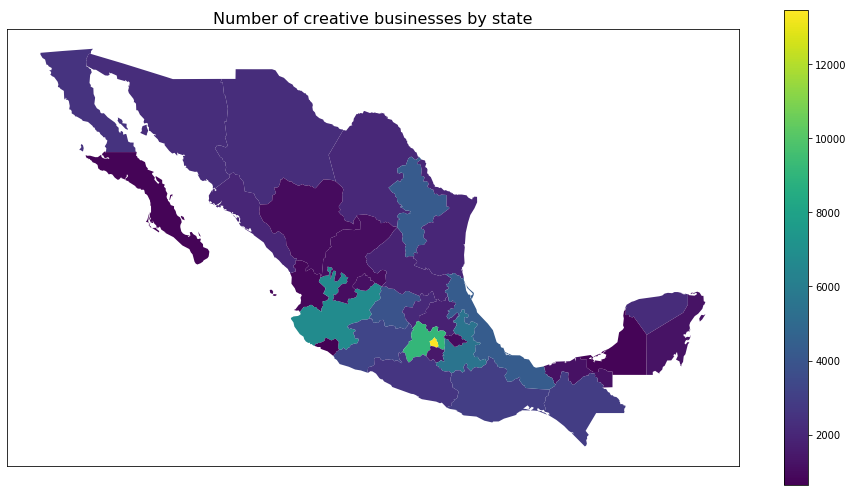

In [50]:
fig,ax = plt.subplots(figsize=(13,7))

#Graficar cuentas de negocios
state_creative_polys.plot('state',ax=ax,cmap='viridis',legend=True)

ax.set_title('Number of creative businesses by state',size=16)

#Invisibilzar el axis
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


plt.tight_layout()

plt.savefig(os.path.join(fig_dir,'{today}_total_business_map.png'.format(today=today_str)))


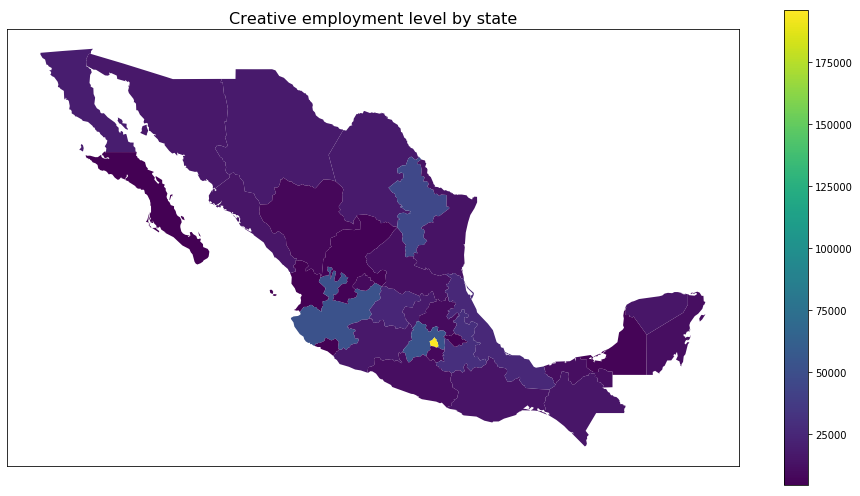

In [51]:
fig,ax = plt.subplots(figsize=(13,7))

#Graficar cuentas de negocios
state_creative_polys.plot('employment_estimate',ax=ax,cmap='viridis',legend=True)

ax.set_title('Creative employment level by state',size=16)

#Invisibilizar el axis
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


plt.tight_layout()

plt.savefig(os.path.join(fig_dir,'{today}_employment_estimate_map.png'.format(today=today_str)))

In [52]:
#¿Qué porcentaje representan los 5 estados con más industrias creativas y empleos?
print(state_creative_counts.sort_values(ascending=False)[:5]/state_creative_counts.sum())
print(state_employment_estimates.sort_values(ascending=False)[:5]/state_employment_estimates.sum())

ciudad de méxico                   0.147415
méxico                             0.099893
jalisco                            0.074030
puebla                             0.060809
veracruz de ignacio de la llave    0.047194
Name: state, dtype: float64
state
ciudad de méxico    0.271774
méxico              0.074745
jalisco             0.072891
nuevo león          0.063250
puebla              0.041858
Name: employment_estimate, dtype: float64


#### Crear gráfica que mida los niveles de concentración en distintos sectores creativos


In [53]:
#Podríamos incluir esta función en la clase anterior
def get_state_employment_estimates(df):
    '''
    This function extracts, for each state-size distribution table,
    an estimate of employment based on company sizebands
    '''
    
    #We melt the dataframe to simplify processing
    #We need to reset the index to use it as the id var when melting
    df_melted = pd.melt(df.reset_index(drop=False),id_vars='state')
    
    df_melted['midpoint'] = [get_midpoint(x) for x in df_melted['employee_sizeband']]
    
    #Multiply the midpoint by number of businesses
    df_melted['employment_estimate'] = df_melted['midpoint']*df_melted['value']
    
    #Regroup
    df_aggregate = df_melted.groupby('state')['employment_estimate'].sum()
    
    return(df_aggregate)


def lorenz_plot(shares_df,name_for_title,ax=ax):
    '''
    Function that takes a dataframe with shares of activity by observation and returns 
    a figure plotting them buy ranking.
    
    '''
    
    #Hace un loop sobre cada columna, la ordena y la grafica. Podemos jugar con los colores para resaltar
    #los sectores creativos y all_sectors
    
    for x in shares_df.columns:
        ax.plot(np.array(shares_df.loc[:,x].sort_values(ascending=False)),
                c='red' if x=='all_creative' else 'black' if x=='all_sectors' else sector_map_lookup[x],
                linewidth=4 if x=='all_creative' else 4 if x=='all_sectors' else 3,
           #alpha=0.9 if x not in ['all_sectors','all_creative'] else 1
               )

    ax.legend(labels=shares_df.columns,fontsize=14)
    ax.set_title("{name}:State share of total by state ranking".format(name=name_for_title),size=16)

    ax.set_yticklabels([100*x for x in ax.get_yticks()],size=12)
    ax.set_xticks(np.arange(len(shares_df)))
    ax.set_xlabel('State position',fontsize=12)  
    ax.set_ylabel('% of all {name} activity'.format(name=name_for_title),fontsize=14)  
    
    return(ax)
    
    

In [54]:
#¿están las industrias creativas más concentradas que otros sectores?


# Obtenemos los porcentajes sectoriales, porcentajes creativos y porcentajes totales
creative_subsector_shares = pd.crosstab(cis.state,cis.creative_sector, normalize=1)
creative_industries_shares = cis.state.value_counts(normalize=True)
creative_industries_shares.name = 'all_creative'

#Todos los sectores
all_sectors_state_counts = pd.concat([x[2][0] for x in denue_eda_outputs],sort=True).reset_index(
    drop=False).groupby('index')['state'].sum()
all_sectors_state_shares = all_sectors_state_counts/all_sectors_state_counts.sum()
all_sectors_state_shares.index = [x.lower().strip() for x in all_sectors_state_shares.index]
all_sectors_state_shares.name = 'all_sectors'

#Porcentajes estatales
all_state_shares = pd.concat([creative_subsector_shares,creative_industries_shares,
                              all_sectors_state_shares],axis=1,sort=True)

#Algo de empleo:
#Subsector creativo
#Crea niveles de empleo total, pivotea y normaliza
creative_subsector_empl_shares = pd.pivot_table(
    cis.groupby(['state','creative_sector'])['employment_estimate'].sum().reset_index(drop=False),
    index='state',columns='creative_sector',values='employment_estimate').apply(lambda x: x/x.sum(),axis=0)

#Todas las industrias creativas
all_cis_state_employment = cis.groupby(['state'])['employment_estimate'].sum()
all_cis_state_empl_shares = all_cis_state_employment/all_cis_state_employment.sum()

all_cis_state_empl_shares.name = 'all_creative'

#Toda la economía
all_sectors_employment_state = pd.concat(
    [get_state_employment_estimates(x[2][4]) for x in denue_eda_outputs],axis=1,sort=True).sum(axis=1)

all_sectors_employment_state.index = [x.lower().strip() for x in all_sectors_employment_state.index]

#Crear porcentajes
all_sectors_empl_state_share = all_sectors_employment_state/all_sectors_employment_state.sum()
all_sectors_empl_state_share.name = 'all_sectors'

all_state_empl_shares = pd.concat([creative_subsector_empl_shares,all_cis_state_empl_shares,
                                  all_sectors_empl_state_share],axis=1)

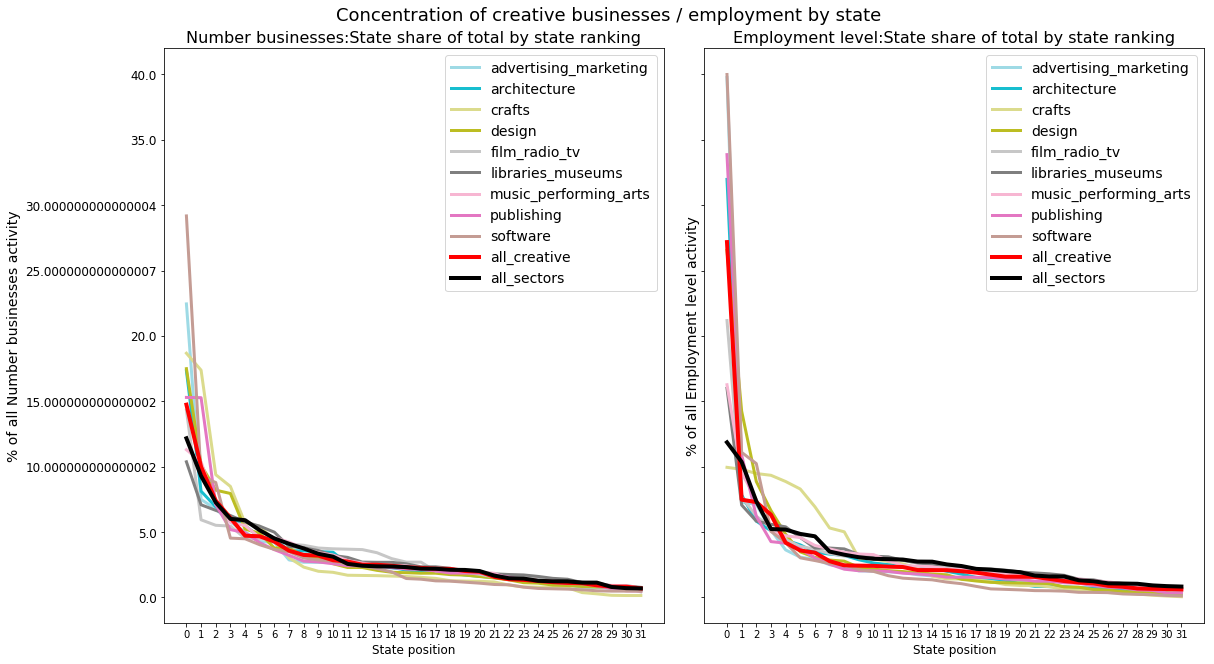

In [55]:
#Finalmente: grafica

#Gráfica
sector_colors = plt.cm.get_cmap('tab20_r').colors[:len(all_state_shares.columns[:-1])]

sector_map_lookup = {x:y for x,y in zip(all_state_shares.columns,sector_colors)}


fig,ax = plt.subplots(figsize=(17,9),ncols=2,sharey=True)

lorenz_plot(all_state_shares,ax=ax[0],name_for_title='Number businesses')
lorenz_plot(all_state_empl_shares,ax=ax[1],name_for_title='Employment level')

plt.tight_layout()

fig.suptitle('Concentration of creative businesses / employment by state',y=1.02,size=18)

plt.savefig(os.path.join(fig_dir,'{date}_lorenz_states.pdf'.format(date=today_str)),bbox_inches='tight')


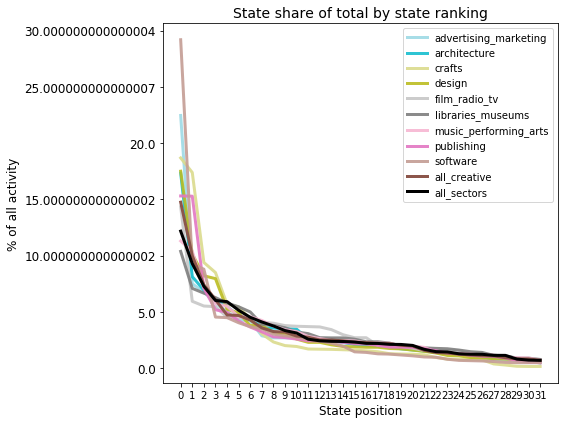

In [56]:
#Gráfica
sector_colors = plt.cm.get_cmap('tab20_r').colors[:len(all_state_shares.columns[:-1])]

sector_map_lookup = {x:y for x,y in zip(all_state_shares.columns,sector_colors)}

fig,ax = plt.subplots(figsize=(8,6))

for x in all_state_shares.columns:
    ax.plot(np.array(all_state_shares.loc[:,x].sort_values(ascending=False)),
           c=sector_map_lookup[x] if x!='all_sectors' else 'black',linewidth=3,
           alpha=0.9 if x not in ['all_sectors','all_creative'] else 1)

ax.legend(labels=all_state_shares.columns)
ax.set_title("State share of total by state ranking",size=14)

ax.set_yticklabels([100*x for x in ax.get_yticks()],size=12)
ax.set_xticks(np.arange(len(all_state_shares)))
ax.set_xlabel('State position',size=12)  
ax.set_ylabel('% of all activity',size=12)  

plt.tight_layout()

### Especialización

In [57]:
# Hay que calcular medidas de especialización

#Esta función calcula LQs

#Funciones
def create_lq_df(df,year=None):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    
    if year!=None:
        lqs['period'] = year
    
    return(lqs)

In [58]:
def process_counts_to_get_lqs(subsector_df,creative_df,all_sectors_df):
    '''
    This function takes a subsector df, creative df and all sectors df
    and operates on them to return a creative LQ df. 
    
    '''
    
    creative_all_state = pd.concat([creative_df,all_sectors_df],axis=1)
    creative_all_state.columns=['creative_industries','all_industries']

    creative_all_state['not_creative'] =creative_all_state['all_industries'] - creative_all_state['creative_industries']
    
    
    #Tenemos todo para calcular el LQ
    #Usamos la función que acabamos de definir. Combinamos datos creativos 
    #con datos no creativos para normalizar con el total de la localidad.
    #Eliminamos los datos no creativos al final porque no los queremos incluir en el reporte.

    creative_subsector_state_lq,creative_industries_state_lq = [
        create_lq_df(pd.concat([x,creative_all_state['not_creative']],axis=1)).drop('not_creative',axis=1) for
        x in [subsector_df,creative_df]]

    #Ahora combinamos los subsectores e industria para hacer mapas

    creative_state_lq = pd.concat([creative_industries_state_lq,creative_subsector_state_lq],axis=1)

    creative_state_lq.rename(columns={0:'all_creative'},inplace=True)

    return(creative_state_lq)

In [59]:
#Creamos una tabla con cuentas de compañías creativas por estado y sector creativo

#This simply pivots a grouped df where we counted the number of unique ids in every state-sector combination
creative_subsector_state = pd.pivot_table(
    cis.groupby(['state','creative_sector'])['id'].count().reset_index(drop=False),
    index='state',
    columns='creative_sector',values='id')

creative_subsector_state.head()

#También calcularmos el total de industrias creativas por estado, sumando los renglones de arriba
creative_industries_state =creative_subsector_state.sum(axis=1)

In [60]:
#Y combinamos esto con el número total del sector

#Totales por estado
#Concatenamos y sumamos los totales de la compañía que extraímos antes
all_state = pd.concat([x[2][0] for x in denue_eda_outputs],axis=1,sort=True).sum(axis=1)

#Hay que hacer el índice minúsculas para el merge
#También hay que quitar espacios en blanco
all_state.index = [x.lower().strip() for x in all_state.index]

creative_state_lq = process_counts_to_get_lqs(creative_subsector_state,creative_industries_state,all_state)

In [61]:
creative_state_lq.head()

,all_creative,advertising_marketing,architecture,crafts,design,film_radio_tv,libraries_museums,music_performing_arts,publishing,software
state,,,,,,,,,,
aguascalientes,1.109554,1.254000,1.428467,0.693706,2.024678,0.663515,0.680739,1.135121,0.935487,1.726834
baja california,1.154503,1.206330,1.497684,0.686515,1.268132,1.551983,0.757437,1.182382,1.141433,1.162137
baja california sur,1.193078,1.380194,1.902742,0.533818,1.317169,1.696921,1.638392,1.296374,0.710159,0.698553
campeche,1.024179,0.964956,1.730036,0.180033,0.862781,1.612541,1.105116,1.148852,0.839968,0.855569
chiapas,0.854033,0.717383,0.684737,0.251932,0.610671,1.088683,1.039707,1.219447,0.740833,0.290857


In [62]:
state_creative_lqs_polys = pd.merge(estados,creative_state_lq.reset_index(drop=False),left_on='ESTADO',
                               right_on='state')

In [63]:
def plot_map(polygon_df,sector,discretised=False,ax=ax):
    '''
    This function takes a polygon df and a variable and returns a map. We can ask it to discretise the data
    into deciles too. 
    
    '''
    
    #If we want to discretise the data we transform the sector variable into deciles
    if discretised!=False:
        polygon_df[sector]= pd.qcut(polygon_df[sector],q=np.arange(0,1.1,0.1),
                                    labels=False,duplicates='drop')
        
    polygon_df.plot(sector,ax=ax,cmap='bwr',legend=False,edgecolor='black',
                                 linewidth=0.5)

    ax.set_title('{x}'.format(x=sector),size=16)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

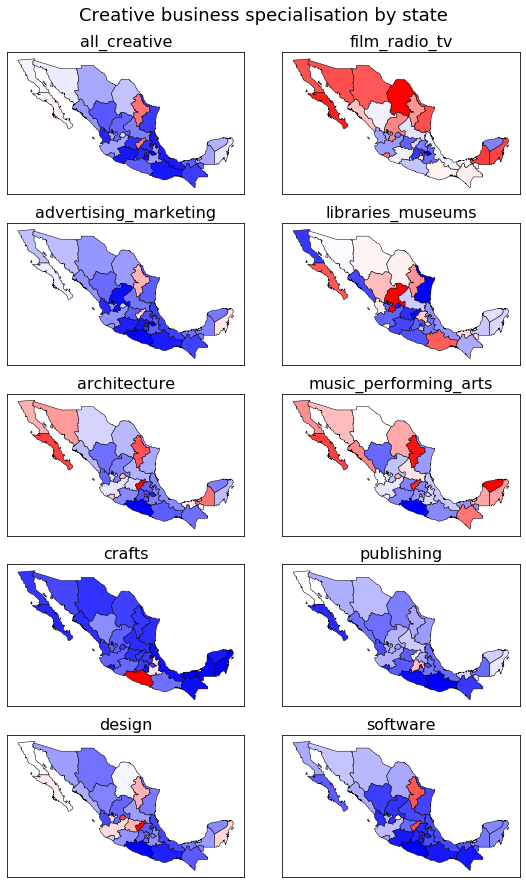

In [64]:
#Y hacemos los mapas
#Aún no añadimos las leyendas - 
#Las gráficas no necesariamente se pueden comparar porque la escala de color está basada en la distribución para cada variable

fig,ax = plt.subplots(figsize=(8,12),nrows=5,ncols=2)

for num,sector in enumerate(creative_state_lq.columns):
    
    if num<5:
        col=0
        row=num
    else:
        col=1
        row=num-5
    
    plot_map(polygon_df=state_creative_lqs_polys,sector=sector,ax=ax[row][col])
    
fig.suptitle('Creative business specialisation by state',y=1.02,size=18)

plt.tight_layout()

plt.savefig(os.path.join(fig_dir,'{date}_business_spec_maps.png'.format(date=today_str)),bbox_inches='tight')


In [65]:
# Hay que hacer algo similar para el empleo.

#Crear LQs de empleo
#Obtener estimados de empleo por subsector
cr_subsector_employment_state = pd.pivot_table(cis.groupby(
    ['state','creative_sector'])['employment_estimate'].sum().reset_index(drop=False),
                                               index='state',
                                               columns='creative_sector',
                                               values='employment_estimate')

#Obtener empleo de industrias creativas
all_creative_employment_state = cr_subsector_employment_state.sum(axis=1)

#También necesitamos estimados del epleo por lugar
all_sectors_employment_state = pd.concat(
    [get_state_employment_estimates(x[2][4]) for x in denue_eda_outputs],axis=1,sort=True).sum(axis=1)

all_sectors_employment_state.index = [x.lower().strip() for x in all_sectors_employment_state.index]

#Igual que lo que hicimos en el apartado anterior
creative_state_lq_emp =process_counts_to_get_lqs(cr_subsector_employment_state,all_creative_employment_state,
                                                all_sectors_employment_state)

#Combinar con polígonos para hacer mapas
state_creative_emp_lqs_polys = pd.merge(estados,creative_state_lq_emp.reset_index(drop=False),left_on='ESTADO',
                               right_on='state')



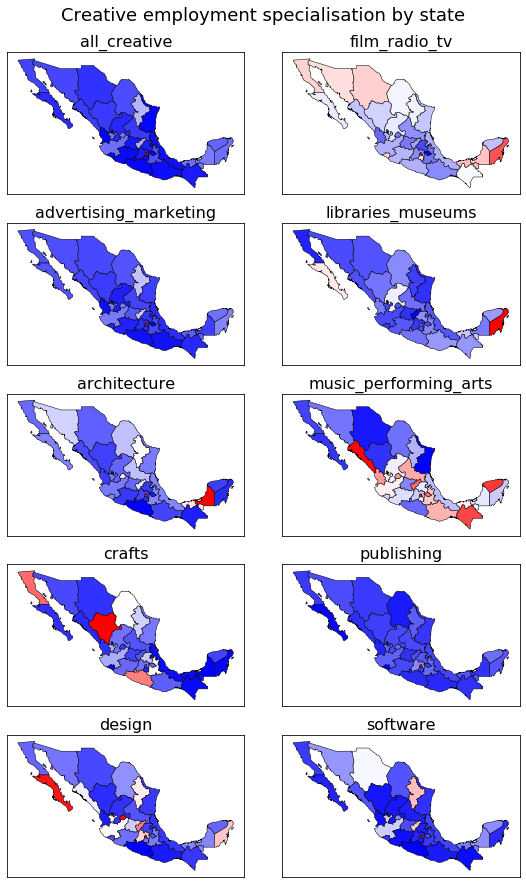

In [66]:
#Y hacemos mapas.
#Aún sin leyendas

fig,ax = plt.subplots(figsize=(8,12),nrows=5,ncols=2)

for num,sector in enumerate(creative_state_lq_emp.columns):
    
    if num<5:
        col=0
        row=num
    else:
        col=1
        row=num-5
    
    plot_map(polygon_df=state_creative_emp_lqs_polys,sector=sector,ax=ax[row][col])
    
fig.suptitle('Creative employment specialisation by state',y=1.02,size=18)

plt.tight_layout()

plt.savefig(os.path.join(fig_dir,'{date}_empl_spec_maps.png'.format(date=today_str)),bbox_inches='tight')


A lot of concentration in Mexico DF and Nuevo León with some exceptions like Film Radio and TV in the North or Durango and Guerrero in Crafts

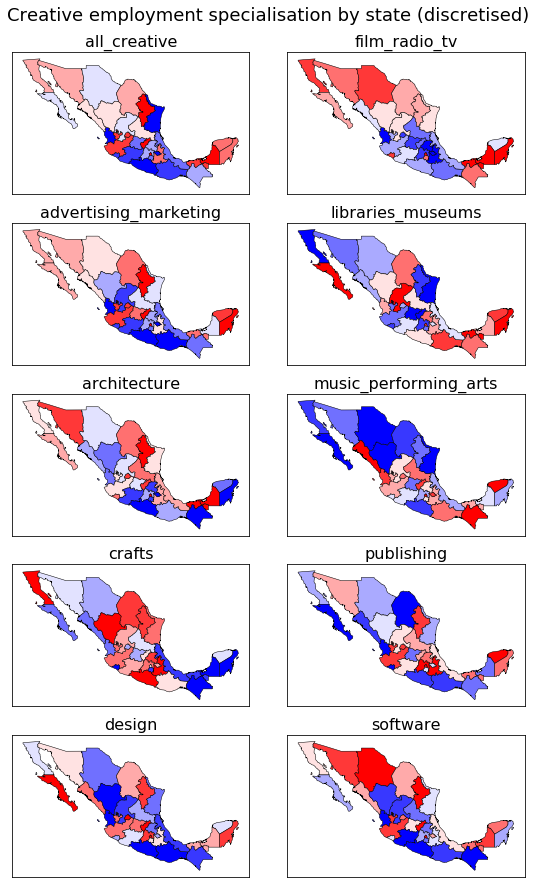

In [67]:
#Aquí estamos haciendo discretas las distribuciones que graficamos (en deciles)
#Los colores de los estados son comparables

fig,ax = plt.subplots(figsize=(8,12),nrows=5,ncols=2)

for num,sector in enumerate(creative_state_lq_emp.columns):
    
    if num<5:
        col=0
        row=num
    else:
        col=1
        row=num-5
    
    plot_map(polygon_df=state_creative_emp_lqs_polys,sector=sector,ax=ax[row][col],discretised=True)
    
fig.suptitle('Creative employment specialisation by state (discretised)',y=1.02,size=18)

plt.tight_layout()


Interesante - ¿esto supone clusters trans-estatales?

### Co-locación

In [68]:
def plot_colocation(lq_df,name_for_title,ax=ax):
    '''
    Function that creates a co-location heatmap taking a df with LQs by location (state) as input
    
    '''
    #Create the correlation matrix with the input df
    correlation_matrix = lq_df.corr()
    
    #Plot
    im = ax.imshow(correlation_matrix,cmap='seismic',aspect='auto')
    
    #Colorbar
    fig.colorbar(im,ax=ax)
    
    #Axes
    ax.set_xticks(np.arange(len(correlation_matrix)))
    ax.set_yticks(np.arange(len(correlation_matrix)))
    
    ax.set_xticklabels(correlation_matrix.index,rotation=45,ha='right',size=14)
    ax.set_yticklabels(correlation_matrix.index,size=14)
    
    ax.set_title('{name} co-location'.format(name=name_for_title),size=14)
    return(ax)
    
    
    

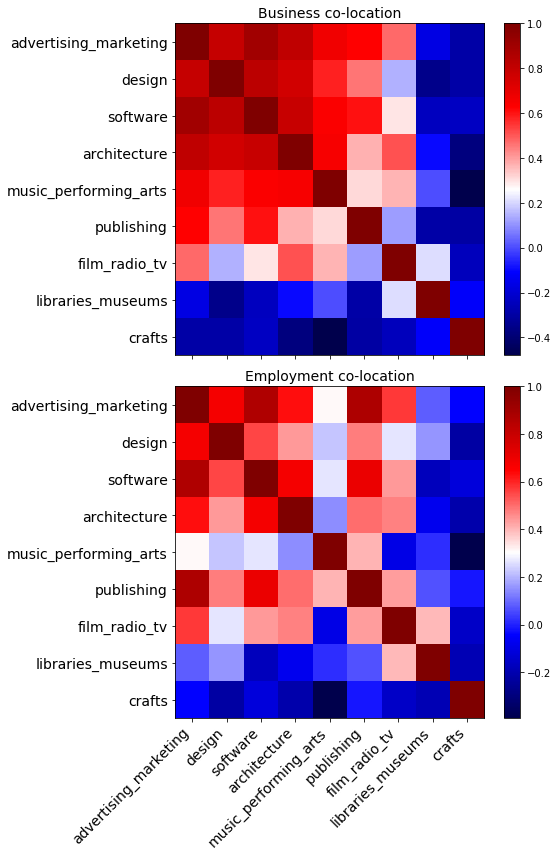

In [69]:
fig,ax = plt.subplots(figsize=(8,12),nrows=2,sharex=True)

sectors_coloc = ['advertising_marketing','design','software','architecture',
                 'music_performing_arts','publishing',
                 'film_radio_tv','libraries_museums','crafts']


plot_colocation(creative_state_lq[sectors_coloc],'Business',ax=ax[0])
plot_colocation(creative_state_lq_emp[sectors_coloc],'Employment',ax=ax[1])

plt.tight_layout()

plt.savefig(os.path.join(fig_dir,'{date}_co_location.pdf'.format(date=today_str)))

In [70]:
def co_location_heatmap(lq_df,name_for_title,ax=ax):
    '''
    Function that creates a co-location heatmap taking a df with LQs by location (state) as input
    
    '''

    #Crear la matrix de correlación
    correlation_matrix = lq_df.corr()
    
    #Gráfica
    im = ax.imshow(correlation_matrix,cmap='seismic',aspect='auto')
    
    #Colorbar
    fig.colorbar(im,ax=ax)
    
    #Ejes
    ax.set_xticks(np.arange(len(correlation_matrix)))
    ax.set_yticks(np.arange(len(correlation_matrix)))
    
    ax.set_ytickslabels(correlation_matrix.index)
    ax.set_xtickslabels(correlation_matrix.index)
    
    ax.set_title('{name} co-location'.format(name=name_for_title))
    return(ax)
    
    
    

## Disponibilidad de contactos

Para concluir nuestra exploración inicial de datos del DENUE, echemos un vistazo a la disponibilidad de los detalles de contacto para las empresas.

* ¿Cuántas tienen direcciones? (Sólo vamos a contar códigos postales)
* ¿Cuántas tienen teléfonos?
* ¿Cuántas tienen correo electrónico?


In [71]:
#Importamos product para calcular el producto cartesiano de las variables

from itertools import product

In [72]:
#Vamos a crear una base de datos reducida con las variables que nos interesan:
#(contacto y características de la empresa relevantes de la encuesta)

#Selección de las variables de contacto

#Variables de contacto
contact_vars = ['postcode','telephone','email','website']

#Metadatos para análisis
metadata_vars = ['employee_sizeband','creative_sector','state']

#Crear base de datos reducida
contact_cis = cis[contact_vars+metadata_vars]

In [73]:
#¿Cuántas tienen código postal, teléfono y correo electrónico?

contact_cis[contact_vars].apply(lambda x: x.isna()==False).mean()

#Todas tienen código postal, 55% teléfono y 22% correo electrónico

postcode     0.990555
telephone    0.539598
email        0.200792
website      0.100943
dtype: float64

In [74]:
#Las keys son las variables que estamos considerando y los 
#valores son los tabulados entre cada categoría y la disponibilidad de detalles de contacto.
# No consideramos código postal porqué está disponible para casi todas las empresas.

cross_tabs = {x+'_'+y:pd.crosstab(contact_cis[x],contact_cis[y].isna()==False,normalize=0) for x,y in 
              product(metadata_vars,['telephone','email'])}



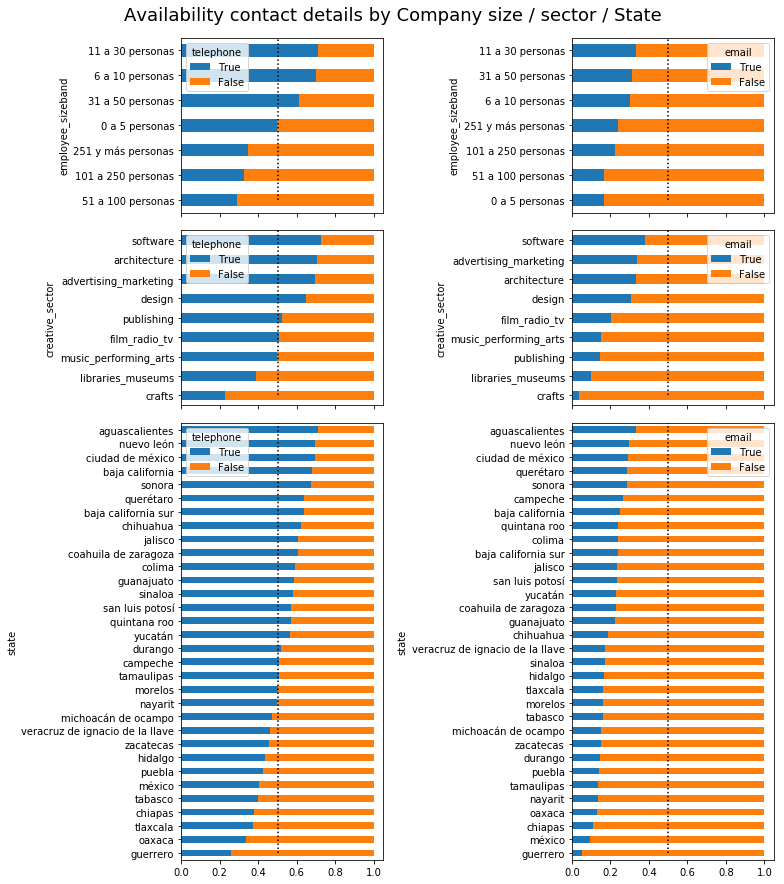

In [75]:
#Graficar detalles de contacto

fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(11,12),gridspec_kw={'height_ratios':[2,2,5]},sharex='col')

#Revisar las variables de metadatos que nos interesan (ej. banda de tamaño, sector, estado) 
for num,x in enumerate(metadata_vars):
    
    #Seleccionar el tabulado correcto
    x = [v for k,v in cross_tabs.items() if x in k]
    
    #Hacerles un loop
    for ct in x:
        #Nos aseguramos que todo sea arrojado en el orden correcto al revisar el nombre de la variable de contacto
        
        #Los tabulados de teléfono siempre van a estar en la columna izquierda
        if ct.columns.name=='telephone':
            
            #Ordenamos los renglones para que los lugares con más disponibilidad estén en la parte superior
            ct.sort_values(True,ascending=True).iloc[:,[1,0]].plot.barh(ax=ax[num][0],stacked=True)
                
            #Añadimos una línea vertical en el 50%
            ax[num][0].vlines(x=0.5,ymin=0,ymax=len(ct),linestyle=':')
    
        #El tabulado de correo electrónico siempre va a estar en la columna derecha
        else:
            ct.sort_values(True,ascending=True).iloc[:,[1,0]].plot.barh(ax=ax[num][1],stacked=True)
            
            ax[num][1].vlines(x=0.5,ymin=0,ymax=len(ct),linestyle=':')
    
#Layout   
plt.tight_layout()

#Nombre
fig.suptitle('Availability contact details by Company size / sector / State',y=1.02,size=18)

plt.savefig(os.path.join(fig_dir,'{date}_contact_details_summary'.format(date=today_str)),bbox_inches='tight')

In [76]:
#Concluimos con algunos heatmaps
contact_cis['has_telephone'] = contact_cis.telephone.isna()==False
contact_cis['has_email'] = contact_cis.email.isna()==False


contact_cross = [pd.pivot_table(
    contact_cis.groupby(['creative_sector','state'])[x].mean().reset_index(drop=False),
    index='creative_sector',columns='state',values=x) for x in ['has_telephone','has_email']]


/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:
def make_hm(ct,ax=ax):
    '''
    Takes a crosstab and returns a heatmap
    
    '''
    #Extrae el sector y los estados ordenados
    
    sectors_contact_sorted = ct.mean(axis=1).sort_values(ascending=False).index
    states_contact_sorted = ct.mean(axis=0).sort_values(ascending=False).index

    #Gráficas
    ims = ax.imshow(ct.loc[sectors_contact_sorted,states_contact_sorted],cmap='seismic',aspect='auto',
                   vmax=1,vmin=0)

    #Crea las etiquetas de los ejes 
    ax.set_yticks(np.arange(len(ct.index)))
    ax.set_yticklabels(sectors_contact_sorted,size=12)
    ax.set_xticks(np.arange(len(ct.columns)))
    ax.set_xticklabels(states_contact_sorted,rotation=45,ha='right',size=12)
    
    #Barra de color
    fig.colorbar(ims,ax=ax)

    return(ims)
    

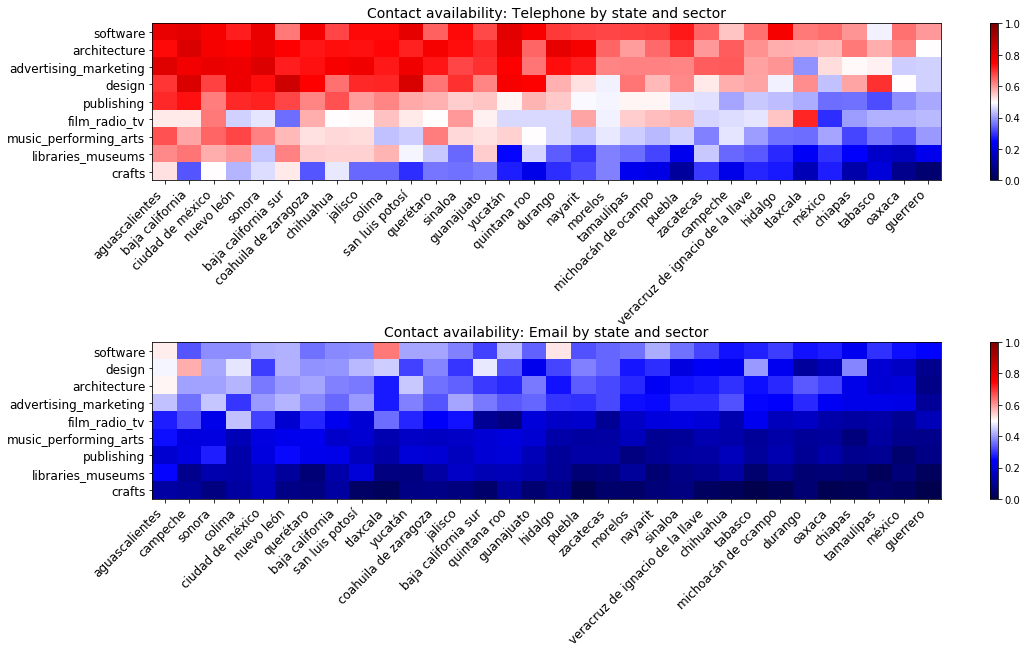

In [78]:
fig,ax = plt.subplots(figsize=(16,9),nrows=2)

make_hm(contact_cross[0],ax=ax[0])
make_hm(contact_cross[1],ax=ax[1])

plt.tight_layout()

ax[0].set_title('Contact availability: Telephone by state and sector',size=14)
ax[1].set_title('Contact availability: Email by state and sector',size=14)


plt.savefig(os.path.join(fig_dir,'{date}_state_sector_availability.pdf'.format(date=today_str)),bbox_inches='tight')

### ¿Y las páginas de internet?

In [79]:
contact_cis['has_website'] =contact_cis['website'].isna()==False

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


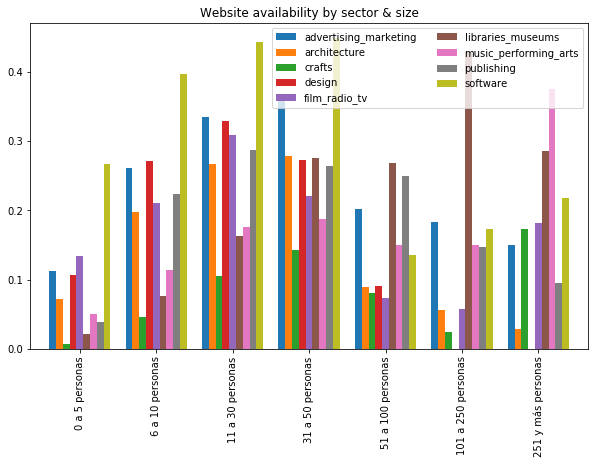

In [80]:
fig,ax = plt.subplots(figsize=(10,6))


pd.pivot_table(
    contact_cis.groupby(
        ['creative_sector','employee_sizeband'])['has_website'].mean().reset_index(drop=False),
    index='creative_sector',columns='employee_sizeband',
    values='has_website').T.loc[sizeb_sorted,:].plot.bar(ax=ax,width=0.8,title='Website availability by sector & size')

ax.legend(ncol=2)


## 2 Análisis longitudinal

Aquí comparamos 2018 y 2015

**Actividades**

* Carga los datos del 2015 y 2018
* Compara crecimiento empresarial por sector y estado
* Revisa características sociodemográficas: nuevo /muerto / creció / estable / declinó. Para todo el país y por estado.

In [81]:
allfiles = os.listdir(denue_dir)
files_2015 = [x for x in allfiles if re.search(r'denue_[0-9\-]+_25022015_csv', x)]
files_2018 = [x for x in allfiles if re.search(r'denue_00_[0-9\-]+_1118_csv', x)]

In [82]:
all_data_2015 = crear_dataframe(files_2015)
all_data_2018 = crear_dataframe(files_2018)

denue_11_25022015_csv.zip
denue_55_25022015_csv.zip
denue_46591-46911_25022015_csv.zip


/usr/local/Cellar/ipython/7.8.0/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


denue_51_25022015_csv.zip
denue_48-49_25022015_csv.zip


/usr/local/Cellar/ipython/7.8.0/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (18,25,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


denue_54_25022015_csv.zip
denue_93_25022015_csv.zip
denue_61_25022015_csv.zip
denue_21_25022015_csv.zip
denue_71_25022015_csv.zip
denue_46321-46531_25022015_csv.zip


/usr/local/Cellar/ipython/7.8.0/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (25,34) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


denue_46111_25022015_csv.zip


/usr/local/Cellar/ipython/7.8.0/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (25,36) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


denue_62_25022015_csv.zip
denue_43_25022015_csv.zip
denue_72_25022015_csv.zip
denue_53_25022015_csv.zip
denue_22_25022015_csv.zip
denue_31-33_25022015_csv.zip


/usr/local/Cellar/ipython/7.8.0/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (25,33) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


denue_46112-46311_25022015_csv.zip
denue_56_25022015_csv.zip
denue_52_25022015_csv.zip
denue_81_25022015_csv.zip
denue_23_25022015_csv.zip
denue_00_21_1118_csv.zip
denue_00_61_1118_csv.zip
denue_00_11_1118_csv.zip
denue_00_43_1118_csv.zip
denue_00_56_1118_csv.zip
denue_00_51_1118_csv.zip
denue_00_72_1118_csv.zip
denue_00_93_1118_csv.zip
denue_00_81_1118_csv.zip
denue_00_48-49_1118_csv.zip
denue_00_31-33_1118_csv.zip
denue_00_46591-46911_1118_csv.zip
denue_00_46111_1118_csv.zip
denue_00_46321-46531_1118_csv.zip
denue_00_53_1118_csv.zip
denue_00_54_1118_csv.zip
denue_00_46112-46311_1118_csv.zip
denue_00_62_1118_csv.zip
denue_00_22_1118_csv.zip
denue_00_55_1118_csv.zip
denue_00_52_1118_csv.zip
denue_00_23_1118_csv.zip
denue_00_71_1118_csv.zip


In [83]:
all_data_2015 = pd.concat([x[0] for x in all_data_2015]).reset_index(drop=True)
all_data_2018 = pd.concat([x[0] for x in all_data_2018]).reset_index(drop=True)

In [84]:
all_data_2015.columns = [x+'_2015' for x in all_data_2015.columns]
all_data_2018.columns = [x+'_2018' for x in all_data_2018.columns]

In [85]:
all_data_2015['state_2015'] = [x if x!='DISTRITO FEDERAL' else 'CIUDAD DE MÉXICO' for x in all_data_2015['state_2015']]
all_data_2018['state_2018'] = [x if x!='DISTRITO FEDERAL' else 'CIUDAD DE MÉXICO' for x in all_data_2018['state_2018']]

In [86]:
all_data_merged = pd.merge(all_data_2015,all_data_2018,left_on='id_2015',right_on='id_2018',how='outer')

In [87]:
pd.crosstab(all_data_merged['creative_sector_2015'],all_data_merged['creative_sector_2018'])

creative_sector_2018,advertising_marketing,architecture,crafts,design,film_radio_tv,libraries_museums,music_performing_arts,publishing,software
creative_sector_2015,,,,,,,,,
advertising_marketing,12733,29,1,21,45,0,4,39,11
architecture,11,6058,0,4,0,0,0,0,1
crafts,0,0,10116,0,0,0,0,0,0
design,17,6,1,2477,0,0,0,4,2
film_radio_tv,0,0,0,1,2590,0,1,0,1
libraries_museums,0,0,0,0,0,5897,8,2,0
music_performing_arts,9,1,0,1,1,26,25450,14,1
publishing,8,4,1,2,1,0,1,19312,4
software,12,11,0,3,0,0,2,1,3122


Issue: Some companies have changed sectors between periods. Is this because they were misclassified at some point or because they changed industries. This is to be checked with INEGI.

Shall we focus only on those that remained stable??

In [88]:
pd.crosstab(all_data_merged['state_2015'],all_data_merged['state_2018'])

state_2018,AGUASCALIENTES,BAJA CALIFORNIA,BAJA CALIFORNIA SUR,CAMPECHE,CHIAPAS,CHIHUAHUA,CIUDAD DE MÉXICO,COAHUILA DE ZARAGOZA,COLIMA,DURANGO,...,QUINTANA ROO,SAN LUIS POTOSÍ,SINALOA,SONORA,TABASCO,TAMAULIPAS,TLAXCALA,VERACRUZ DE IGNACIO DE LA LLAVE,YUCATÁN,ZACATECAS
state_2015,,,,,,,,,,,,,,,,,,,,,
AGUASCALIENTES,54963,0,0,0,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0
BAJA CALIFORNIA,0,112558,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BAJA CALIFORNIA SUR,0,0,31471,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
CAMPECHE,0,0,0,38697,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHIAPAS,0,0,0,0,186258,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
CHIHUAHUA,0,0,0,0,0,116887,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CIUDAD DE MÉXICO,0,0,0,0,0,1,448921,1,0,0,...,1,1,0,0,1,0,0,2,0,0
COAHUILA DE ZARAGOZA,0,0,0,0,0,0,1,102142,0,1,...,0,0,0,0,0,0,0,0,0,0
COLIMA,0,1,0,0,0,0,0,0,34574,0,...,0,0,0,0,0,0,0,0,0,0


Hay más estabilidad en los estados. Sería interesante utilizar estos datos para revisar la mobilidad de la compañía.

### Compara creativos y no creativos

In [89]:
#Considera crecimiento a nivel sector

def get_creative_totals(df,sector_var):
    '''
    Takes a df with creative and non-creative companies and returns the total number of companies, as well as non creative and total creatives
    
    Sector vals selects creative sectors and groups by
    
    '''
    
    #Etiquetar no creativos
    df[sector_var] = df[sector_var].apply(lambda x: x if pd.isnull(x)==False else 'not_creative')
    
    #Agrupa por sector creativo y cuenta totales
    counts = df.groupby(sector_var).size()
    
    counts['all_creative']= counts[[x for x in counts.index if x!='not_creative']].sum()
    
    counts.name='totals_'+sector_var.split('_')[-1]
    return(counts)

In [90]:
growth_comparison = pd.concat([get_creative_totals(x,y) for x,y in zip([all_data_2015,all_data_2018],
                                                                      ['creative_sector_2015','creative_sector_2018'])],axis=1)

In [91]:
growth_comparison['growth'] = (growth_comparison['totals_2018']/growth_comparison['totals_2015'])-1

Text(0.5, 1.0, 'Growth in number of companies 2015-2018')

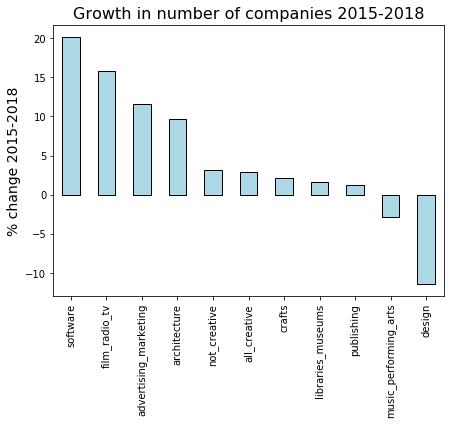

In [92]:
fig,ax = plt.subplots(figsize=(7,5))


(100*growth_comparison.growth.sort_values(ascending=False)).plot.bar(color='lightblue',edgecolor='black',ax=ax)

ax.set_ylabel('% change 2015-2018',size=14)
ax.set_title('Growth in number of companies 2015-2018',size=16)

Los sectores más dinámicos son software; cine, radio y TV; publicidad y mercadotecnia y arquitectura.

El declive del diseño está explicado por cambios en la clasificación, no desaparición de empresas.

In [93]:
# Hacer lo mismo pero con estados...

#Considera el crecimiento a nivel sector

def get_creative_totals_state(df,sector_var,state_var):
    '''
    Takes a df with creative and non-creative companies and returns the total number of companies, as well as non creative and total creatives
    
    Sector vals selects creative sectors and groups by
    
    '''
    
    #Etiqueta no creativos
    
    df_2 = df.copy()
    
    df_2[sector_var] = df_2[sector_var].apply(lambda x: 'creative' if pd.isnull(x)==False else 'not_creative')
    
    #df['']
    
    #Group by creative sector and produce counts
    counts = df_2.groupby([sector_var,state_var]).size()
    
    counts['all_creative']= counts[[x for x in counts.index if x!='not_creative']].sum()
    
    counts.name='totals_'+sector_var.split('_')[-1]
    return(counts)

In [94]:
state_counts = pd.concat([get_creative_totals_state(all_data_2015,'creative_sector_2015','state_2015'),
                        get_creative_totals_state(all_data_2018,'creative_sector_2018','state_2018')],axis=1)

In [95]:
state_counts['growth'] = state_counts['totals_2018']/state_counts['totals_2015']

In [96]:
state_counts = state_counts.reset_index(drop=False)

In [97]:
state_counts.head()

,creative_sector_2015,state_2015,totals_2015,totals_2018,growth
0,creative,AGUASCALIENTES,55462,57389,1.034745
1,creative,BAJA CALIFORNIA,113873,120714,1.060076
2,creative,BAJA CALIFORNIA SUR,32076,35006,1.091346
3,creative,CAMPECHE,39077,40616,1.039384
4,creative,CHIAPAS,187769,190273,1.013336


Text(0.5, 1.0, 'Creative industries growth by state, 2015-2018')

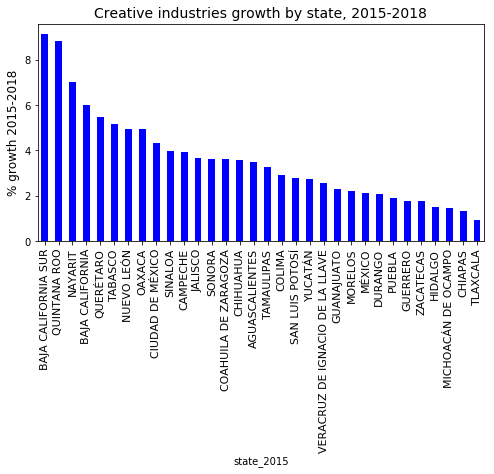

In [98]:
fig,ax = plt.subplots(figsize=(8,4))


(100*state_counts.loc[state_counts.creative_sector_2015=='creative'].set_index('state_2015')['growth'].sort_values(ascending=False)-100).plot.bar(color='blue',
                                                                                                                                                 ax=ax)

ax.set_xticklabels([x.get_text().strip() for x in ax.get_xticklabels()],size=11)

ax.set_ylabel('% growth 2015-2018',size=12)
ax.set_title('Creative industries growth by state, 2015-2018',size=14)

#### Combinar datos para analizar con más detalle

In [99]:
sizeb_sorted_dict = {
    8:'dead',
    -1:'new',
    0:'0 a 5 personas',
    6:'101 a 250 personas',
    2:'11 a 30 personas',
    7:'251 y más personas',
    4:'31 a 50 personas',
    5:'51 a 100 personas',
    1:'6 a 10 personas'}

sizeb_sorted_list = [x[1] for x in sorted(sizeb_sorted_dict.items(),key=lambda x:x[0])]

sizeb_sorted_dict_ = {i:k for k,i in sizeb_sorted_dict.items()}

In [100]:
def compare_comps(x,y):
    '''
    
    Compares status in 2015 and 2018 and returns an status
    
    '''
    
    if x=='new':
        return('new')
    elif y=='dead':
        return('died')
    elif y>x:
        return('grew')
    elif x>y:
        return('declined')
    elif x==y:
        return('stable')

In [101]:
all_data_merged['employee_sizeband_2015'] = ['new' if pd.isnull(x)==True else x for x in all_data_merged['employee_sizeband_2015']]
all_data_merged['employee_sizeband_2018'] = ['dead' if pd.isnull(x)==True else x for x in all_data_merged['employee_sizeband_2018']]


#Crea una variable que nos dice la transición entre 20181 y 2019: Nuevo, creció, estable, declinó, murió.
all_data_merged['transition_15_to_18'] = [compare_comps(x,y) for x, y in zip(all_data_merged['employee_sizeband_2015'],
                                                                             all_data_merged['employee_sizeband_2018'])]

In [102]:
#Crea una variable de un sólo sector
all_data_merged['sector_both'] = [x if pd.isnull(x)==False else y for x,y in zip(all_data_merged['creative_sector_2015'],
                                                                                 all_data_merged['creative_sector_2018'])] 

all_data_merged['state_both'] = [x if pd.isnull(x)==False else y for x,y in zip(all_data_merged['state_2015'],
                                                                                 all_data_merged['state_2018'])] 

In [103]:
#Define una función que arroja una comparación para cada sección de los datos en la que nos queramos concentrar.

def do_demographics(df,name):
    '''
    Extracts firms demographics from a df
    
    
    '''
    
    values = df['transition_15_to_18'].value_counts()
    values.name=name
    
    return(values)


def normalise_demographics(dem):
    '''
    Normalises the demographics so everything is expressed as a share of the total in 2015.
    This involves normalising by not new companies.
    
    '''
    
    not_new = dem[[x for x in dem.index if x!='new']].sum()
    
    return(dem/not_new)

In [104]:
sector_dems = [normalise_demographics(
    do_demographics(all_data_merged.loc[all_data_merged['sector_both']==sec],sec)) for sec in set(all_data_merged['sector_both'])]

In [105]:
#Orden de las variables para la visualización
order_dems = ['died','declined','stable','grew','new']

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


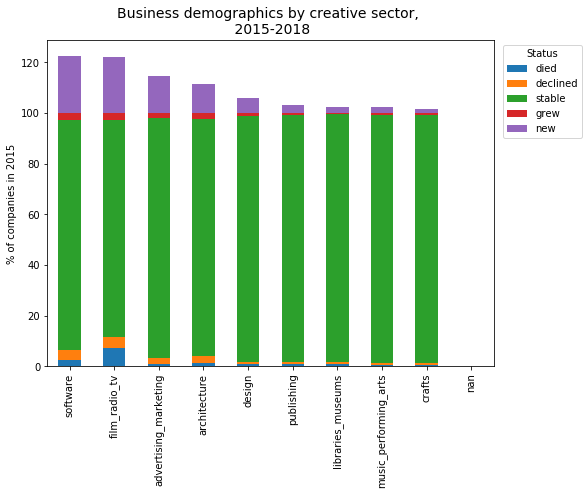

In [106]:
fig, ax = plt.subplots(figsize=(8,6))


(100*pd.concat(sector_dems,axis=1).T[order_dems].sort_values('new',ascending=False)).plot.bar(stacked=True,ax=ax)

ax.set_title('Business demographics by creative sector, \n 2015-2018',size=14)

ax.set_ylabel('% of companies in 2015')
ax.legend(bbox_to_anchor=(1.01,1),title='Status')

#### Análisis por estados

In [107]:
#Lo mismo para estados

creative_sectors = set(all_data_merged['sector_both'])
#creative_sectors.remove('not_creative') # El archivo de naics_lookup no contiene empresas "not_creative"

In [108]:
#Extrae las características demográficas de los negocios creativos por estado

state_dems = [normalise_demographics(
    do_demographics(
        all_data_merged.loc[
            (all_data_merged['state_both']==state) & ([x in list(creative_sectors) for x in all_data_merged['sector_both']])],state))for state in set(
    all_data_merged['state_both'])]

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


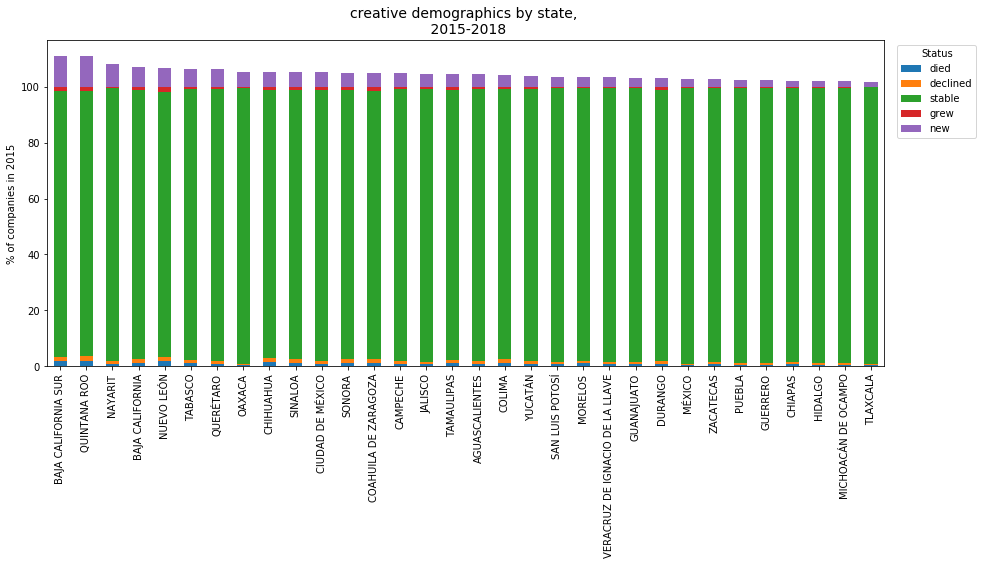

In [109]:
fig, ax = plt.subplots(figsize=(15,6))


(100*pd.concat(state_dems,axis=1).T[order_dems].sort_values('new',ascending=False)).plot.bar(stacked=True,ax=ax)

ax.set_title('creative demographics by state, \n 2015-2018',size=14)

ax.set_ylabel('% of companies in 2015')
ax.set_xticklabels([x.get_text().strip() for x in ax.get_xticklabels()])

ax.legend(bbox_to_anchor=(1.01,1),title='Status')

#### Mapa de actividades de startups creativas en México

In [110]:
#Mapa de actividades startup

creative_startup_rates = pd.concat(state_dems,axis=1).loc['new'].T.reset_index(drop=False)

creative_startup_rates['index'] = [x.lower().strip() for x in creative_startup_rates['index']]

startup_polys = pd.merge(estados,creative_startup_rates,left_on='ESTADO',right_on='index')

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Share of creative startups')

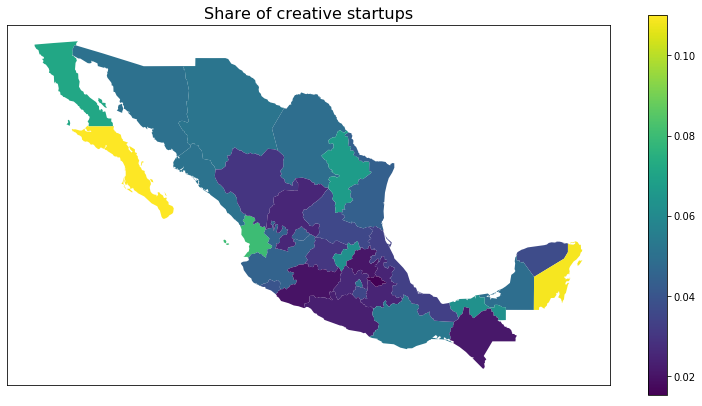

In [111]:
fig,ax = plt.subplots(figsize=(13.5,7))

startup_polys.plot('new',legend=True,ax=ax)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Share of creative startups',size=16)